In [5]:
%pip install -q scikit-learn



Note: you may need to restart the kernel to use updated packages.


In [46]:
# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Import data handling and preprocessing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

# Import visualization libraries
import matplotlib.pyplot as plt

# Import OS for file path handling
import os

###  URL Define

In [47]:
# Define the URL for the dataset
dataset_url = "https://raw.githubusercontent.com/Bishwaprotapi/Infectious_Disease_Using_BLSTM_BGRU_Model/main/Infectious_Disease_2001_2014.csv"

### Load the dataset

In [48]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_url)
print("Dataset loaded successfully.")
print(f"Shape of the dataset: {df.shape}")
print("First 10 rows of the dataset:")
print(df.head(10))

Dataset loaded successfully.
Shape of the dataset: (141777, 10)
First 10 rows of the dataset:
     Disease      County  Year     Sex  Count  Population   Rate  CI.lower  \
0  Amebiasis  California  2001   Total    571    34514777  1.654     1.521   
1  Amebiasis  California  2001  Female    176    17340743  1.015     0.871   
2  Amebiasis  California  2001    Male    365    17174034  2.125     1.913   
3  Amebiasis  California  2002   Total    442    34940334  1.265     1.150   
4  Amebiasis  California  2002  Female    145    17555714  0.826     0.697   
5  Amebiasis  California  2002    Male    279    17384620  1.605     1.422   
6  Amebiasis  California  2003   Total    403    35390986  1.139     1.030   
7  Amebiasis  California  2003  Female    127    17783924  0.714     0.595   
8  Amebiasis  California  2003    Male    261    17607062  1.482     1.308   
9  Amebiasis  California  2004   Total    359    35754827  1.004     0.903   

   CI.upper Unstable  
0     1.796           
1

In [ ]:
# Define the name of the target column
# IMPORTANT: Please verify 'Disease' is the correct target column name in your dataset.
# If your target column has a different name (e.g., 'Infection_Type', 'Diagnosis'),
# update 'target_column_name' accordingly.
target_column_name = 'Disease'

# Separate features (X) and the target variable (y)
# X will contain all columns except the target column.
# y will contain the target column (our 'Target_Variable').
X = df.drop(columns=[target_column_name])
y = df[target_column_name]

print(f"Target column identified: '{target_column_name}'")
print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("\nFirst 5 rows of features (X):")
print(X.head())
print("\nFirst 5 values of target (y):")
print(y.head())

# If the target variable is categorical (e.g., text labels), encode it using LabelEncoder.
# This is a common step for classification tasks to convert string labels into numerical format.
if y.dtype == 'object' or pd.api.types.is_categorical_dtype(y):
    print("\nTarget variable is categorical. Applying Label Encoding...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    # Replace the original 'y' with the encoded version, maintaining index and name for consistency
    y = pd.Series(y_encoded, name=target_column_name + '_encoded', index=y.index)
    print("Label encoding applied to target variable.")
    print(f"Original classes: {label_encoder.classes_}")
    print(f"Encoded values (first 5): {y.head()}")
    # Store the label_encoder object if you need to inverse transform predictions back to original labels later.
    # e.g., self.label_encoder = label_encoder if this were part of a class.
else:
    print("\nTarget variable is numerical. No Label Encoding applied.")

Target column identified: 'Disease'
Shape of features (X): (141777, 9)
Shape of target (y): (141777,)

First 5 rows of features (X):
       County  Year     Sex  Count  Population   Rate  CI.lower  CI.upper  \
0  California  2001   Total    571    34514777  1.654     1.521     1.796   
1  California  2001  Female    176    17340743  1.015     0.871     1.176   
2  California  2001    Male    365    17174034  2.125     1.913     2.355   
3  California  2002   Total    442    34940334  1.265     1.150     1.389   
4  California  2002  Female    145    17555714  0.826     0.697     0.972   

  Unstable  
0           
1           
2           
3           
4           

First 5 values of target (y):
0    Amebiasis
1    Amebiasis
2    Amebiasis
3    Amebiasis
4    Amebiasis
Name: Disease, dtype: object

Target variable is categorical. Applying Label Encoding...
Label encoding applied to target variable.
Original classes: ['Amebiasis' 'Anaplasmosis and Ehrlichiosis' 'Babesiosis'
 'Botulism, 

### Data Acquisition: MIT-HIH Dataset

In [58]:
import os
from urllib.parse import urlparse
mit_hih_dataset_url = "https://raw.githubusercontent.com/Bishwaprotapi/Infectious_Disease_Using_BLSTM_BGRU_Model/main/Infectious_Disease_2001_2014.csv"
mit_hih_filename = os.path.basename(urlparse(mit_hih_dataset_url).path)
print(f"MIT-HIH dataset URL defined: '{mit_hih_dataset_url}'")
print(f"Expected main filename for MIT-HIH dataset: '{mit_hih_filename}'")

MIT-HIH dataset URL defined: 'https://raw.githubusercontent.com/Bishwaprotapi/Infectious_Disease_Using_BLSTM_BGRU_Model/main/Infectious_Disease_2001_2014.csv'
Expected main filename for MIT-HIH dataset: 'Infectious_Disease_2001_2014.csv'


In [54]:

mit_hih_data_dir = 'data/MIT-HIH_Dataset'
os.makedirs(mit_hih_data_dir, exist_ok=True)

print(f"MIT-HIH dataset directory set to: {mit_hih_data_dir}")

MIT-HIH dataset directory set to: data/MIT-HIH_Dataset


In [59]:
import requests
import pandas as pd

# Construct the full path for the dataset file
filepath = os.path.join(mit_hih_data_dir, mit_hih_filename)

# Check if the file already exists to avoid re-downloading
if not os.path.exists(filepath):
    print(f"Attempting to download '{mit_hih_filename}' from '{mit_hih_dataset_url}'...")
    try:
        response = requests.get(mit_hih_dataset_url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Successfully downloaded '{mit_hih_filename}' to '{filepath}'")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        print("Please check the URL and your internet connection.")
        raise # Re-raise the exception to stop execution if download fails
else:
    print(f"File '{mit_hih_filename}' already exists at '{filepath}'. Skipping download.")

# Load the dataset into a pandas DataFrame
print(f"\nLoading dataset from '{filepath}' into DataFrame 'df'...")
try:
    df = pd.read_csv(filepath)
    print("Dataset loaded successfully.")
    print(f"Shape of the loaded dataset: {df.shape}")
    print("\nFirst 5 rows of the loaded dataset:")
    print(df.head())
except Exception as e:
    print(f"Error loading the dataset: {e}")
    print("Please ensure the file is a valid CSV and accessible.")
    raise # Re-raise the exception to stop execution if loading fails


Attempting to download 'Infectious_Disease_2001_2014.csv' from 'https://raw.githubusercontent.com/Bishwaprotapi/Infectious_Disease_Using_BLSTM_BGRU_Model/main/Infectious_Disease_2001_2014.csv'...
Successfully downloaded 'Infectious_Disease_2001_2014.csv' to 'data/MIT-HIH_Dataset\Infectious_Disease_2001_2014.csv'

Loading dataset from 'data/MIT-HIH_Dataset\Infectious_Disease_2001_2014.csv' into DataFrame 'df'...
Dataset loaded successfully.
Shape of the loaded dataset: (141777, 10)

First 5 rows of the loaded dataset:
     Disease      County  Year     Sex  Count  Population   Rate  CI.lower  \
0  Amebiasis  California  2001   Total    571    34514777  1.654     1.521   
1  Amebiasis  California  2001  Female    176    17340743  1.015     0.871   
2  Amebiasis  California  2001    Male    365    17174034  2.125     1.913   
3  Amebiasis  California  2002   Total    442    34940334  1.265     1.150   
4  Amebiasis  California  2002  Female    145    17555714  0.826     0.697   

   CI.up

In [60]:
# 1. Missing Values Remover
print("\n--- Handling Missing Values ---")
print("Missing values before handling (showing only columns with missing values):")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])
print("\nMissing values after handling (showing only columns with missing values):")
missing_after = df.isnull().sum()
missing_after_filtered = missing_after[missing_after > 0]
if missing_after_filtered.empty:
    print("No missing values remaining.")
else:
    print(missing_after_filtered)
    print("Warning: Some missing values might still exist if not covered by numerical/categorical types.")



--- Handling Missing Values ---
Missing values before handling (showing only columns with missing values):
Series([], dtype: int64)

Missing values after handling (showing only columns with missing values):
No missing values remaining.


In [61]:
# 2. Outlier Remover (using IQR method)
# Note: This step is also present in a subsequent cell (cell 14).
# Please ensure this is the intended placement or if it's an alternative implementation.
print("\n--- Applying Outlier Removal (IQR Method) ---")

# Identify numerical columns for outlier detection
numerical_cols = df.select_dtypes(include=['number']).columns
outliers_found_any = False

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers_before = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    if outliers_before > 0:
        outliers_found_any = True
        print(f"Column '{col}': Detected {outliers_before} outliers.")
        # Cap outliers to the bounds
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        print(f"  Outliers in '{col}' have been capped to the IQR bounds [{lower_bound:.2f}, {upper_bound:.2f}].")
    # else:
    #     print(f"Column '{col}': No outliers detected within IQR range.")

if not outliers_found_any:
    print("No significant outliers detected in numerical columns using the IQR method.")
else:
    print("\nOutlier removal (IQR capping) process completed.")



--- Applying Outlier Removal (IQR Method) ---
Column 'Count': Detected 25242 outliers.
  Outliers in 'Count' have been capped to the IQR bounds [-1.50, 2.50].
Column 'Population': Detected 16425 outliers.
  Outliers in 'Population' have been capped to the IQR bounds [-546155.50, 986832.50].
Column 'Rate': Detected 29139 outliers.
  Outliers in 'Rate' have been capped to the IQR bounds [-0.30, 0.51].
Column 'CI.lower': Detected 32167 outliers.
  Outliers in 'CI.lower' have been capped to the IQR bounds [-0.01, 0.03].
Column 'CI.upper': Detected 14657 outliers.
  Outliers in 'CI.upper' have been capped to the IQR bounds [-22.98, 42.29].

Outlier removal (IQR capping) process completed.


In [64]:
# 2. Outlier Remover (using IQR method)
print("\n--- Handling Outliers (IQR Method) ---")

# Re-identify numerical columns as they might have changed (though not in this case)
numerical_cols = df.select_dtypes(include=['number']).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before capping
    outliers_lower = df[df[col] < lower_bound].shape[0]
    outliers_upper = df[df[col] > upper_bound].shape[0]
    total_outliers = outliers_lower + outliers_upper

    if total_outliers > 0:
        print(f"Column '{col}': Found {total_outliers} outliers ({outliers_lower} below, {outliers_upper} above).")
        # Cap outliers
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        print(f"Outliers in '{col}' capped to [{lower_bound:.2f}, {upper_bound:.2f}]")
    else:
        print(f"Column '{col}': No significant outliers detected.")

print("\nOutlier handling complete.")



--- Handling Outliers (IQR Method) ---
Column 'Year': No significant outliers detected.
Column 'Count': No significant outliers detected.
Column 'Population': No significant outliers detected.
Column 'Rate': No significant outliers detected.
Column 'CI.lower': No significant outliers detected.
Column 'CI.upper': No significant outliers detected.

Outlier handling complete.


In [65]:
# 3. Etc: Data Type Conversion (e.g., Date/Time columns)
print("\n--- Data Type Conversion (Etc.) ---")

# Attempt to convert a 'Date' or 'Year' column to datetime objects
# Common column names for date information
date_cols_candidates = ['Date', 'Year', 'Month', 'Day', 'Timestamp']
date_column_found = False

for col_name in date_cols_candidates:
    if col_name in df.columns:
        try:
            # If it's just 'Year', it might be an integer, convert to string first if needed
            if col_name == 'Year' and df[col_name].dtype == 'int64':
                df[col_name] = df[col_name].astype(str)
            df[col_name] = pd.to_datetime(df[col_name], errors='coerce')
            print(f"Converted column '{col_name}' to datetime objects.")
            date_column_found = True
            # Check for NaT values introduced by 'coerce'
            if df[col_name].isnull().any():
                print(f"Warning: NaT values introduced in '{col_name}' during conversion. Consider further handling.")
            break # Assume only one primary date column for now
        except Exception as e:
            print(f"Could not convert column '{col_name}' to datetime: {e}")

if not date_column_found:
    print("No common date/time column found or could not be converted.")



--- Data Type Conversion (Etc.) ---
Converted column 'Year' to datetime objects.


In [66]:
print("\n--- Dataset Info After Preprocessing ---")
print(f"Shape of the dataset: {df.shape}")
print("First 5 rows of the dataset after preprocessing:")
print(df.head())
print("\nDataset info:")
df.info()


--- Dataset Info After Preprocessing ---
Shape of the dataset: (141777, 10)
First 5 rows of the dataset after preprocessing:
     Disease      County       Year     Sex  Count  Population    Rate  \
0  Amebiasis  California 2001-01-01   Total    2.5    986832.5  0.5075   
1  Amebiasis  California 2001-01-01  Female    2.5    986832.5  0.5075   
2  Amebiasis  California 2001-01-01    Male    2.5    986832.5  0.5075   
3  Amebiasis  California 2002-01-01   Total    2.5    986832.5  0.5075   
4  Amebiasis  California 2002-01-01  Female    2.5    986832.5  0.5075   

   CI.lower  CI.upper Unstable  
0     0.025     1.796           
1     0.025     1.176           
2     0.025     2.355           
3     0.025     1.389           
4     0.025     0.972           

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141777 entries, 0 to 141776
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Di

### Unbalanced Dataset


--- Visualizing Class Distributions for Potential Imbalance ---
Found 4 categorical columns. Plotting their distributions one by one...

--- Distribution Analysis for column: 'Disease' ---
Value Counts:
Disease
Amebiasis                        2478
Anaplasmosis and Ehrlichiosis    2478
Babesiosis                       2478
Cholera                          2478
Botulism, Other                  2478
                                 ... 
Hepatitis C, Acute                708
Cyclosporiasis                    708
Hepatitis B, Acute                708
Hepatitis E, acute infection      708
Hepatitis A                       708
Name: count, Length: 65, dtype: int64

Value Percentages:
Disease
Amebiasis                        1.75
Anaplasmosis and Ehrlichiosis    1.75
Babesiosis                       1.75
Cholera                          1.75
Botulism, Other                  1.75
                                 ... 
Hepatitis C, Acute               0.50
Cyclosporiasis                   0.50


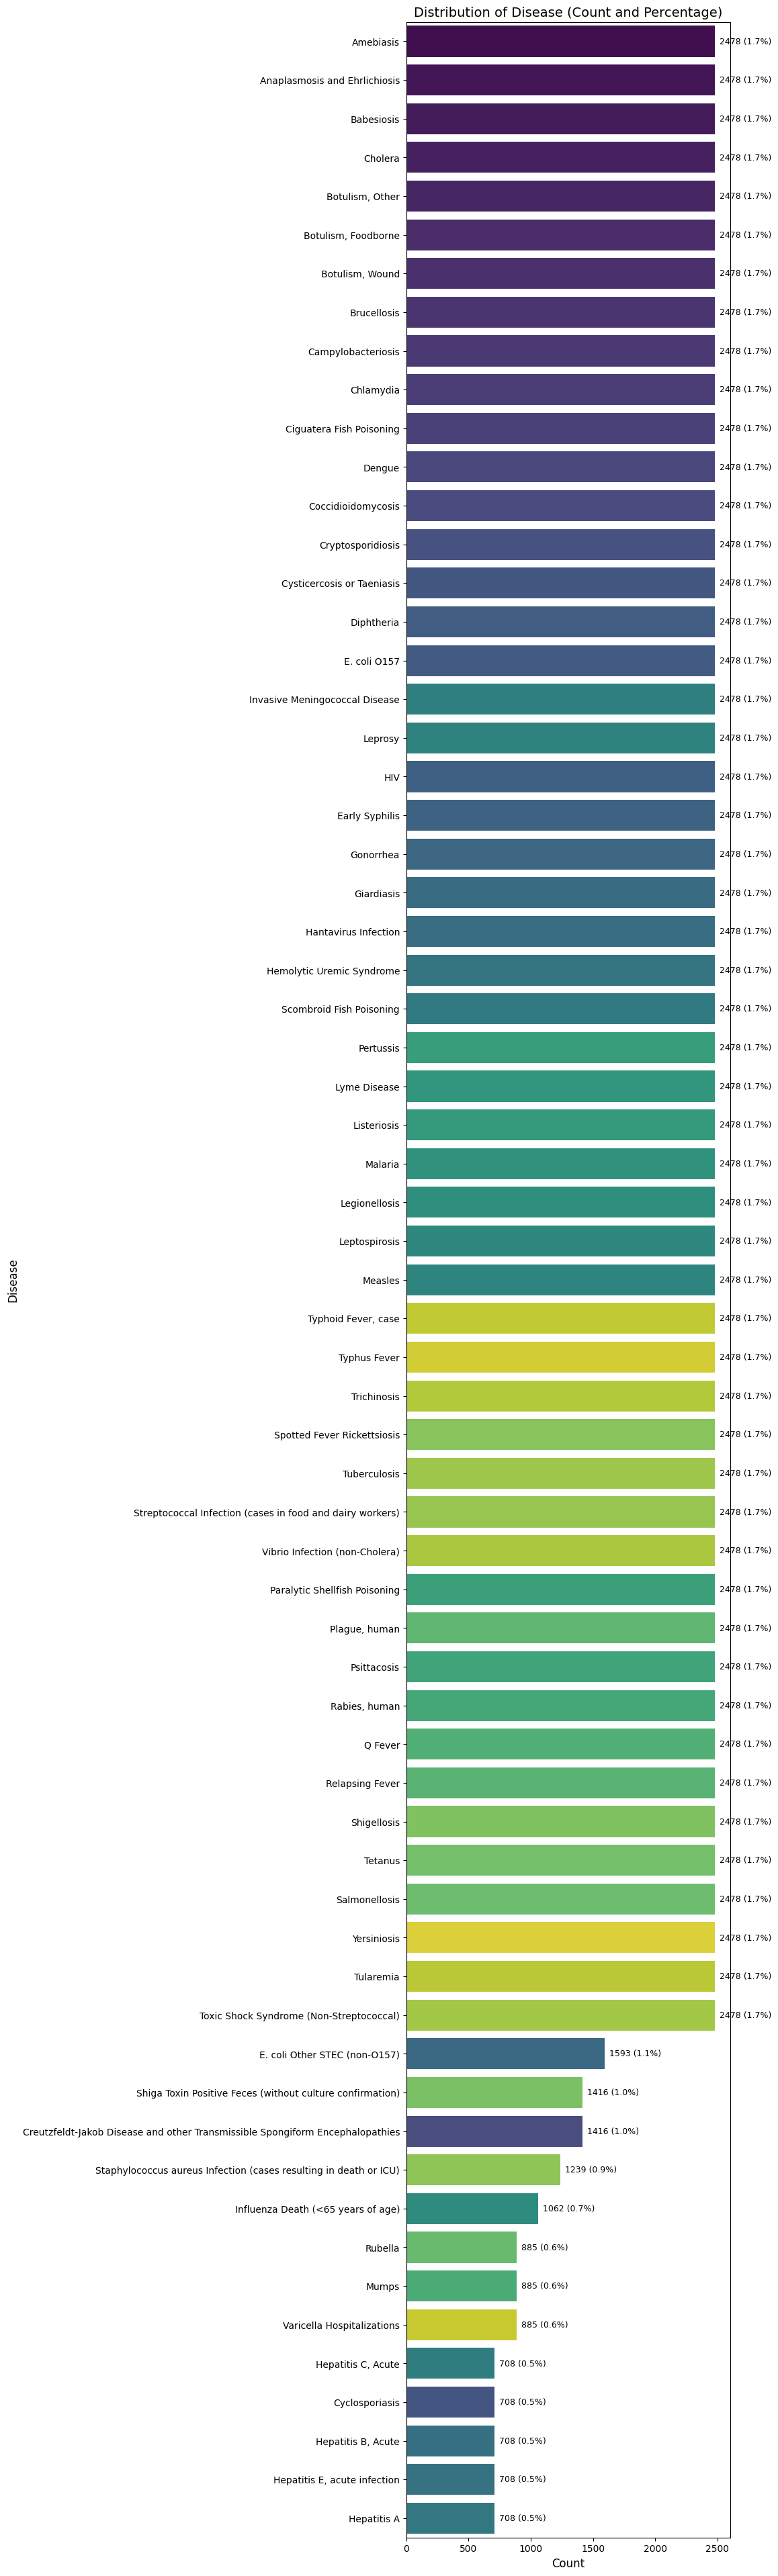


--- Distribution Analysis for column: 'County' ---
Value Counts:
County
California         2403
Alameda            2403
Alpine             2403
Amador             2403
Butte              2403
Calaveras          2403
Colusa             2403
Contra Costa       2403
Del Norte          2403
El Dorado          2403
Fresno             2403
Glenn              2403
Humboldt           2403
Imperial           2403
Inyo               2403
Kern               2403
Kings              2403
Lake               2403
Lassen             2403
Los Angeles        2403
Madera             2403
Modoc              2403
Marin              2403
Mariposa           2403
Mendocino          2403
Merced             2403
Mono               2403
Monterey           2403
Napa               2403
Nevada             2403
Orange             2403
Placer             2403
Plumas             2403
Riverside          2403
Sacramento         2403
San Benito         2403
San Bernardino     2403
San Diego          2403
San Francisco  

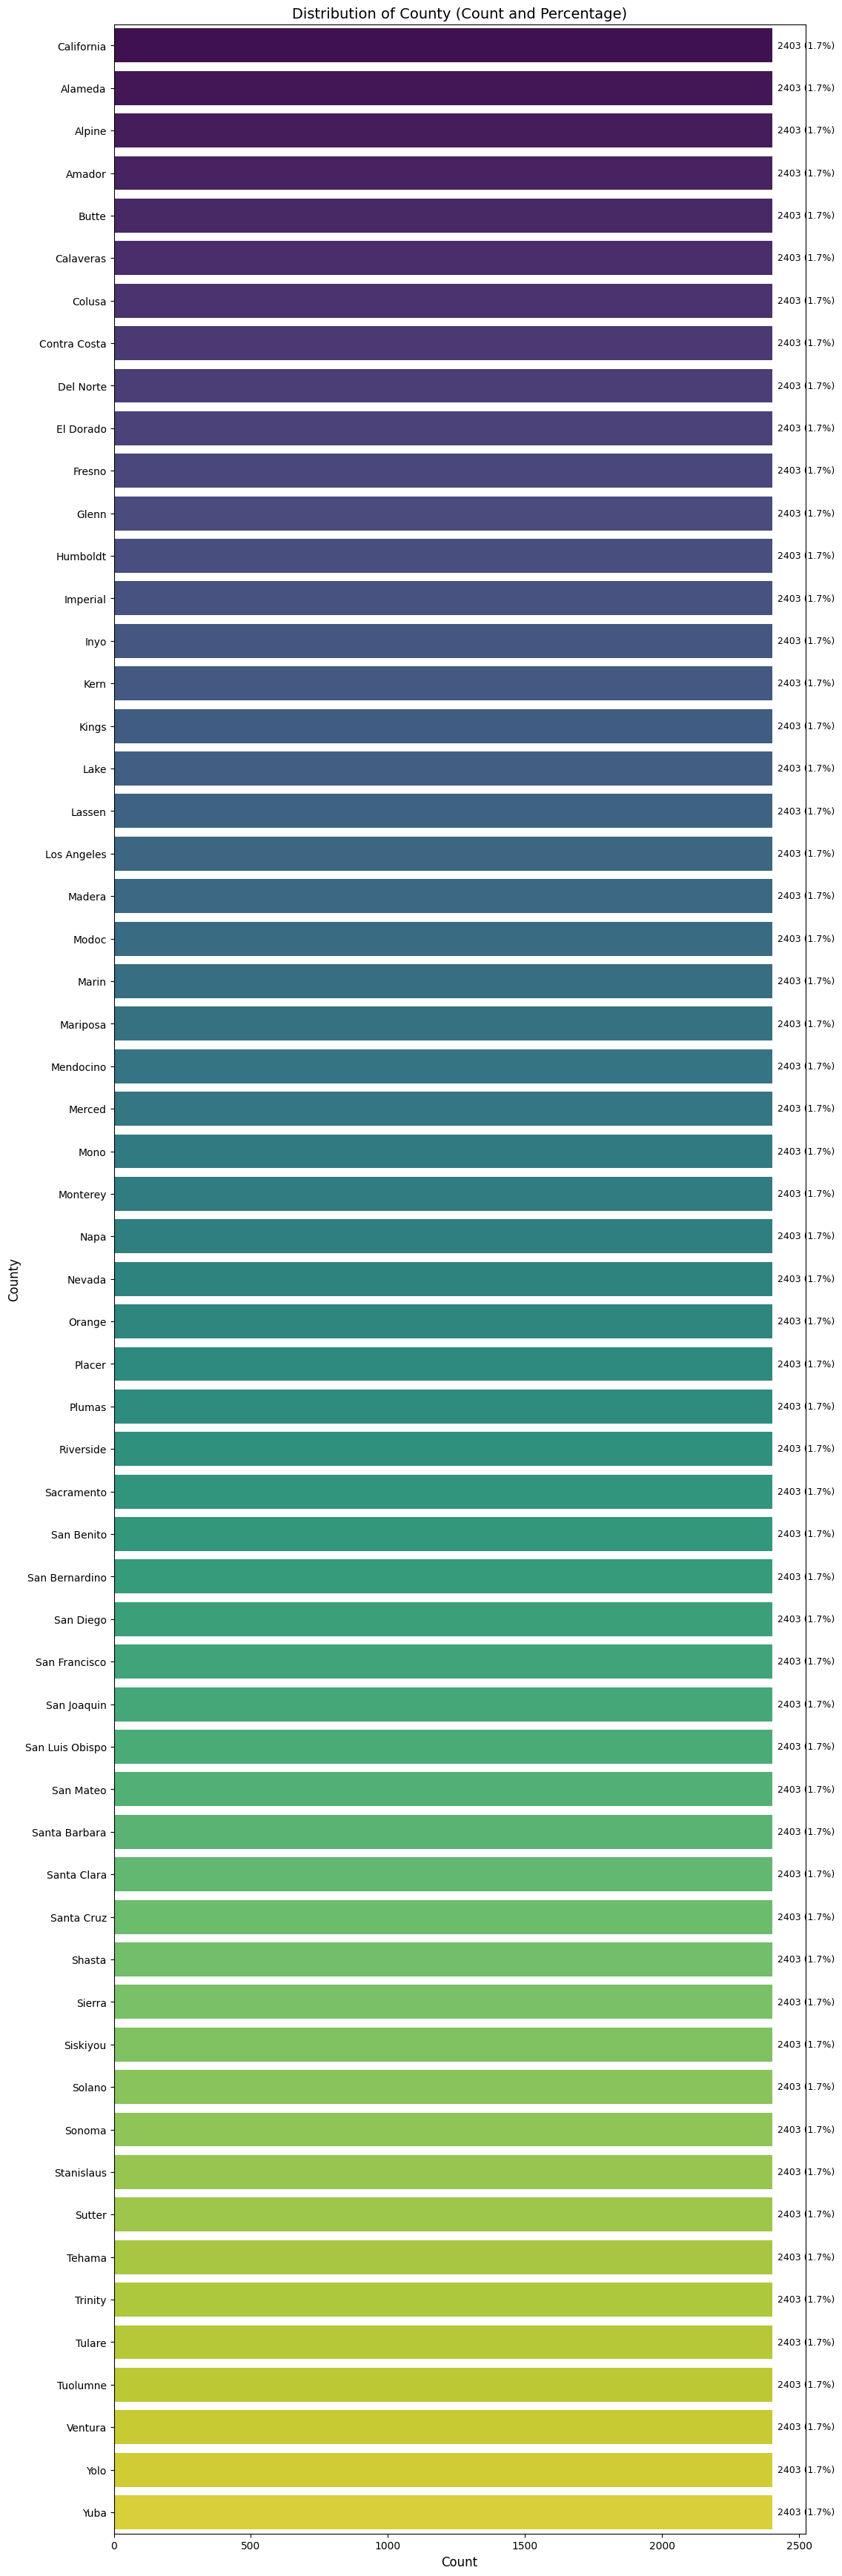


--- Distribution Analysis for column: 'Sex' ---
Value Counts:
Sex
Total     47259
Female    47259
Male      47259
Name: count, dtype: int64

Value Percentages:
Sex
Total     33.33
Female    33.33
Male      33.33
Name: proportion, dtype: float64


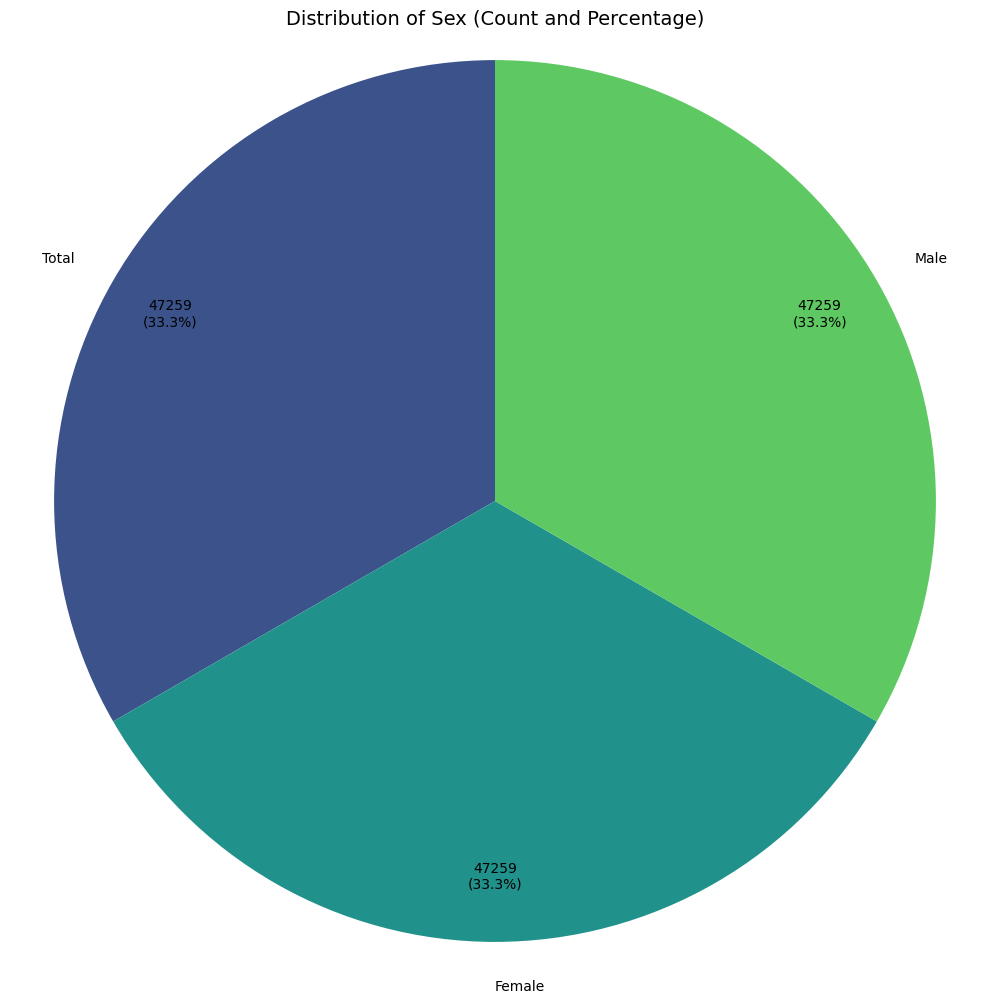


--- Distribution Analysis for column: 'Unstable' ---
Value Counts:
Unstable
-    101036
*     29012
      11729
Name: count, dtype: int64

Value Percentages:
Unstable
-    71.26
*    20.46
      8.27
Name: proportion, dtype: float64


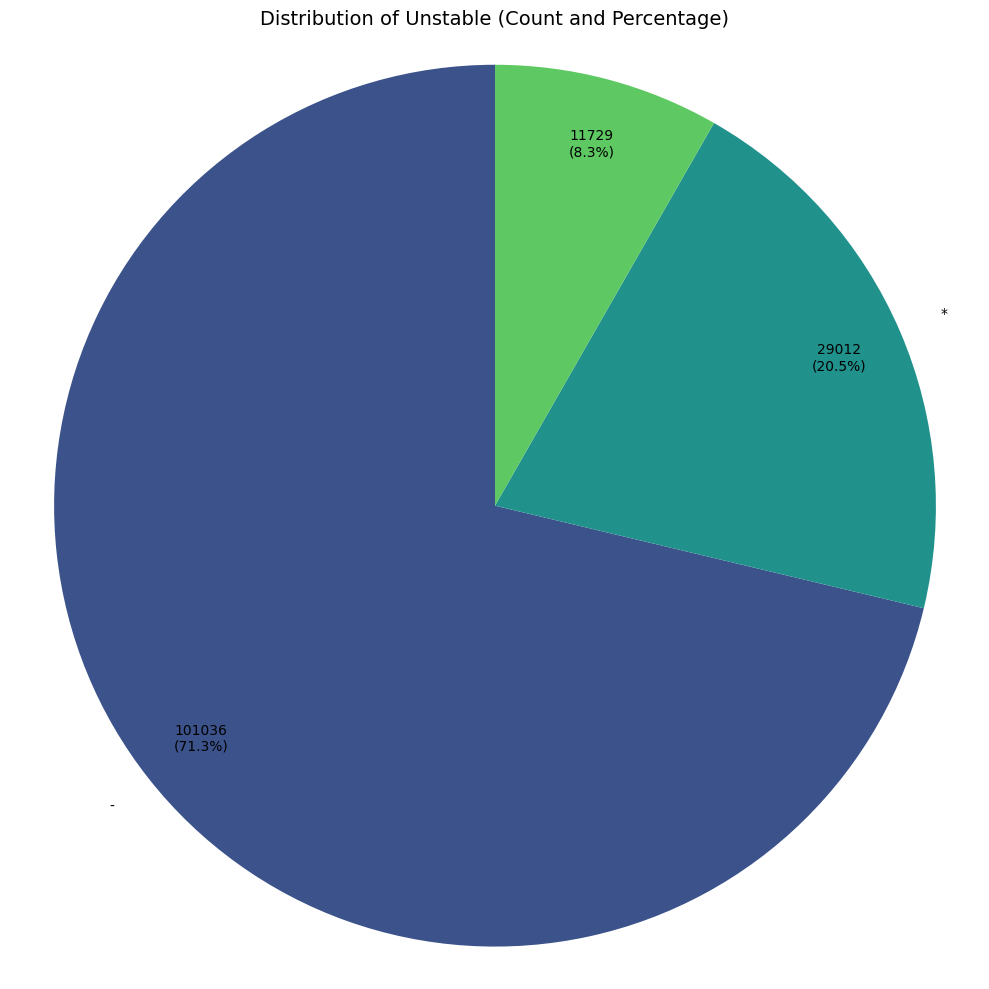


Visualizations complete. Refer to the plots above for class distributions and printed statistics.


In [87]:
# Analyze for Unbalanced Dataset by visualizing class distributions
print("\n--- Visualizing Class Distributions for Potential Imbalance ---")

# Identify categorical columns that might represent target variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

if len(categorical_cols) == 0:
    print("No categorical columns found to visualize for imbalance.")
else:
    print(f"Found {len(categorical_cols)} categorical columns. Plotting their distributions one by one...")
    
    # Import plotting libraries (these are typically available in a Jupyter environment)
    import matplotlib.pyplot as plt
    import seaborn as sns

    for i, col in enumerate(categorical_cols):
        print(f"\n--- Distribution Analysis for column: '{col}' ---")
        value_counts = df[col].value_counts()
        value_percentages = df[col].value_counts(normalize=True) * 100
        
        # Print summary statistics for clarity and quick overview
        print("Value Counts:")
        print(value_counts)
        print("\nValue Percentages:")
        print(value_percentages.round(2)) # Round percentages for cleaner output
        
        # Determine the number of unique categories
        num_unique_categories = df[col].nunique()

        # Conditional visualization:
        # Use a Pie Chart for columns with a small number of unique categories (e.g., 2-7 classes)
        # Use a Horizontal Countplot for columns with more categories for better readability.
        if num_unique_categories > 1 and num_unique_categories <= 7: # Suitable for pie chart
            plt.figure(figsize=(10, 10))
            wedges, texts, autotexts = plt.pie(
                value_counts, 
                labels=value_counts.index, 
                autopct='%1.1f%%', 
                startangle=90, 
                pctdistance=0.85, 
                colors=sns.color_palette('viridis', n_colors=num_unique_categories)
            )
            plt.title(f'Distribution of {col} (Count and Percentage)', fontsize=14)
            plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
            
            # Add count to the autotexts for enhanced clarity
            for j, autotext in enumerate(autotexts):
                autotext.set_text(f"{value_counts.iloc[j]}\n({autotext.get_text()})")
                autotext.set_color('black')
                autotext.set_fontsize(10)
            
            plt.tight_layout()
            plt.show()

        elif num_unique_categories > 7: # More categories, horizontal bar chart is often clearer
            # Adjust figure height dynamically based on the number of categories for better readability
            fig_height = max(7, num_unique_categories * 0.6) 
            plt.figure(figsize=(12, fig_height))
            
            ax = sns.countplot(data=df, y=col, hue=col, palette='viridis', order=value_counts.index, legend=False)
            
            plt.title(f'Distribution of {col} (Count and Percentage)', fontsize=14)
            plt.xlabel('Count', fontsize=12)
            plt.ylabel(col, fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            
            # Add value counts and percentages on the bars for clarity
            total_non_null = len(df[col].dropna())
            for p in ax.patches:
                width = p.get_width() # This is the count for horizontal bars
                if width > 0: # Only label non-zero bars
                    percentage = (width / total_non_null) * 100
                    ax.annotate(f'{int(width)} ({percentage:.1f}%)', # Format as "Count (Percentage%)"
                                (width, p.get_y() + p.get_height() / 2), # Position label at the end of the bar
                                ha='left', va='center', xytext=(5, 0), # Offset text slightly to the right
                                textcoords='offset points', fontsize=9, color='black') # Ensure label visibility

            plt.tight_layout(pad=3.0)
            plt.show()
        else: # num_unique_categories is 1 (or 0, but handled by outer if)
            print(f"Column '{col}' has only one unique value. No distribution to visualize for imbalance.")

    print("\nVisualizations complete. Refer to the plots above for class distributions and printed statistics.")


### Dataset Balancing

In [80]:
print("\n--- Dataset Balancing ---")

# Re-identify categorical columns from the DataFrame 'df' (assuming 'df' is available from previous cells).
# This step is necessary to determine the target column and check for imbalance within this cell,
# as the subsequent cell (cell 20) performs a similar check but its results might not be
# directly available at this insertion point.
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

target_column = None
significant_imbalance_detected_for_balancing = False # Flag to track if imbalance is found for balancing

if len(categorical_cols) == 0:
    print("No categorical columns found to check for imbalance. Skipping dataset balancing.")
else:
    print("Analyzing value distribution in categorical columns to identify a suitable target for balancing:")
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        value_percentages = df[col].value_counts(normalize=True) * 100

        # Define a simple threshold for imbalance (e.g., any class < 10% or > 90%)
        is_imbalanced = (value_percentages < 10).any() or (value_percentages > 90).any()

        # Prioritize columns that contain 'Normal' or 'Discare' (common target classes)
        # and show significant imbalance.
        if ('Normal' in value_counts.index or 'Discare' in value_counts.index) and is_imbalanced:
            target_column = col
            significant_imbalance_detected_for_balancing = True
            print(f"  -> Identified '{target_column}' as the primary target column for balancing (imbalance detected with specific classes).")
            break # Select the first suitable column found

        elif is_imbalanced:
            if target_column is None: # Only set if a more specific target hasn't been found
                target_column = col
                significant_imbalance_detected_for_balancing = True
                print(f"  -> Identified '{target_column}' as a potential target column for balancing (general imbalance detected).")

    if significant_imbalance_detected_for_balancing and target_column:
        print(f"\nSignificant imbalance detected. Proceeding with balancing for target column: '{target_column}'")

        # Separate features (X) and target (y)
        X = df.drop(columns=[target_column])
        y = df[target_column]

        categorical_features_in_X = X.select_dtypes(include=['object', 'category']).columns
        if len(categorical_features_in_X) > 0:
            print(f"One-hot encoding categorical features in X: {list(categorical_features_in_X)}")
            # Assuming pandas is imported as 'pd' in the notebook environment.
            X = pd.get_dummies(X, columns=categorical_features_in_X, drop_first=True)
        

        non_numeric_cols = X.select_dtypes(exclude=['number', 'bool']).columns
        if len(non_numeric_cols) > 0:
            print(f"Warning: Dropping non-numeric columns from X that could not be encoded: {list(non_numeric_cols)}")
            X = X.drop(columns=non_numeric_cols)

        print(f"Original dataset shape: X={X.shape}, y={y.shape}")
        print("Original class distribution:")
        print(y.value_counts())

        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        print("\nDataset balanced using SMOTE.")
        print(f"Resampled dataset shape: X_resampled={X_resampled.shape}, y_resampled={y_resampled.shape}")
        print("New class distribution:")
        print(y_resampled.value_counts())

        df_balanced = pd.concat([X_resampled, y_resampled], axis=1)
        print("\nBalanced dataset stored in 'df_balanced' for further analysis or modeling.")

    else:
        print("No significant imbalance detected in target-like columns, or no suitable target column found for balancing.")
        print("Skipping dataset balancing.")



--- Dataset Balancing ---
Analyzing value distribution in categorical columns to identify a suitable target for balancing:
  -> Identified 'Disease' as a potential target column for balancing (general imbalance detected).

Significant imbalance detected. Proceeding with balancing for target column: 'Disease'
One-hot encoding categorical features in X: ['County', 'Sex', 'Unstable']
Original dataset shape: X=(141777, 67), y=(141777,)
Original class distribution:
Disease
Amebiasis                        2478
Anaplasmosis and Ehrlichiosis    2478
Babesiosis                       2478
Cholera                          2478
Botulism, Other                  2478
                                 ... 
Hepatitis C, Acute                708
Cyclosporiasis                    708
Hepatitis B, Acute                708
Hepatitis E, acute infection      708
Hepatitis A                       708
Name: count, Length: 65, dtype: int64

Dataset balanced using SMOTE.
Resampled dataset shape: X_resampled=(1


--- Visualizing Class Distribution Before and After Balancing ---

--- Original Class Distribution of 'Disease' ---


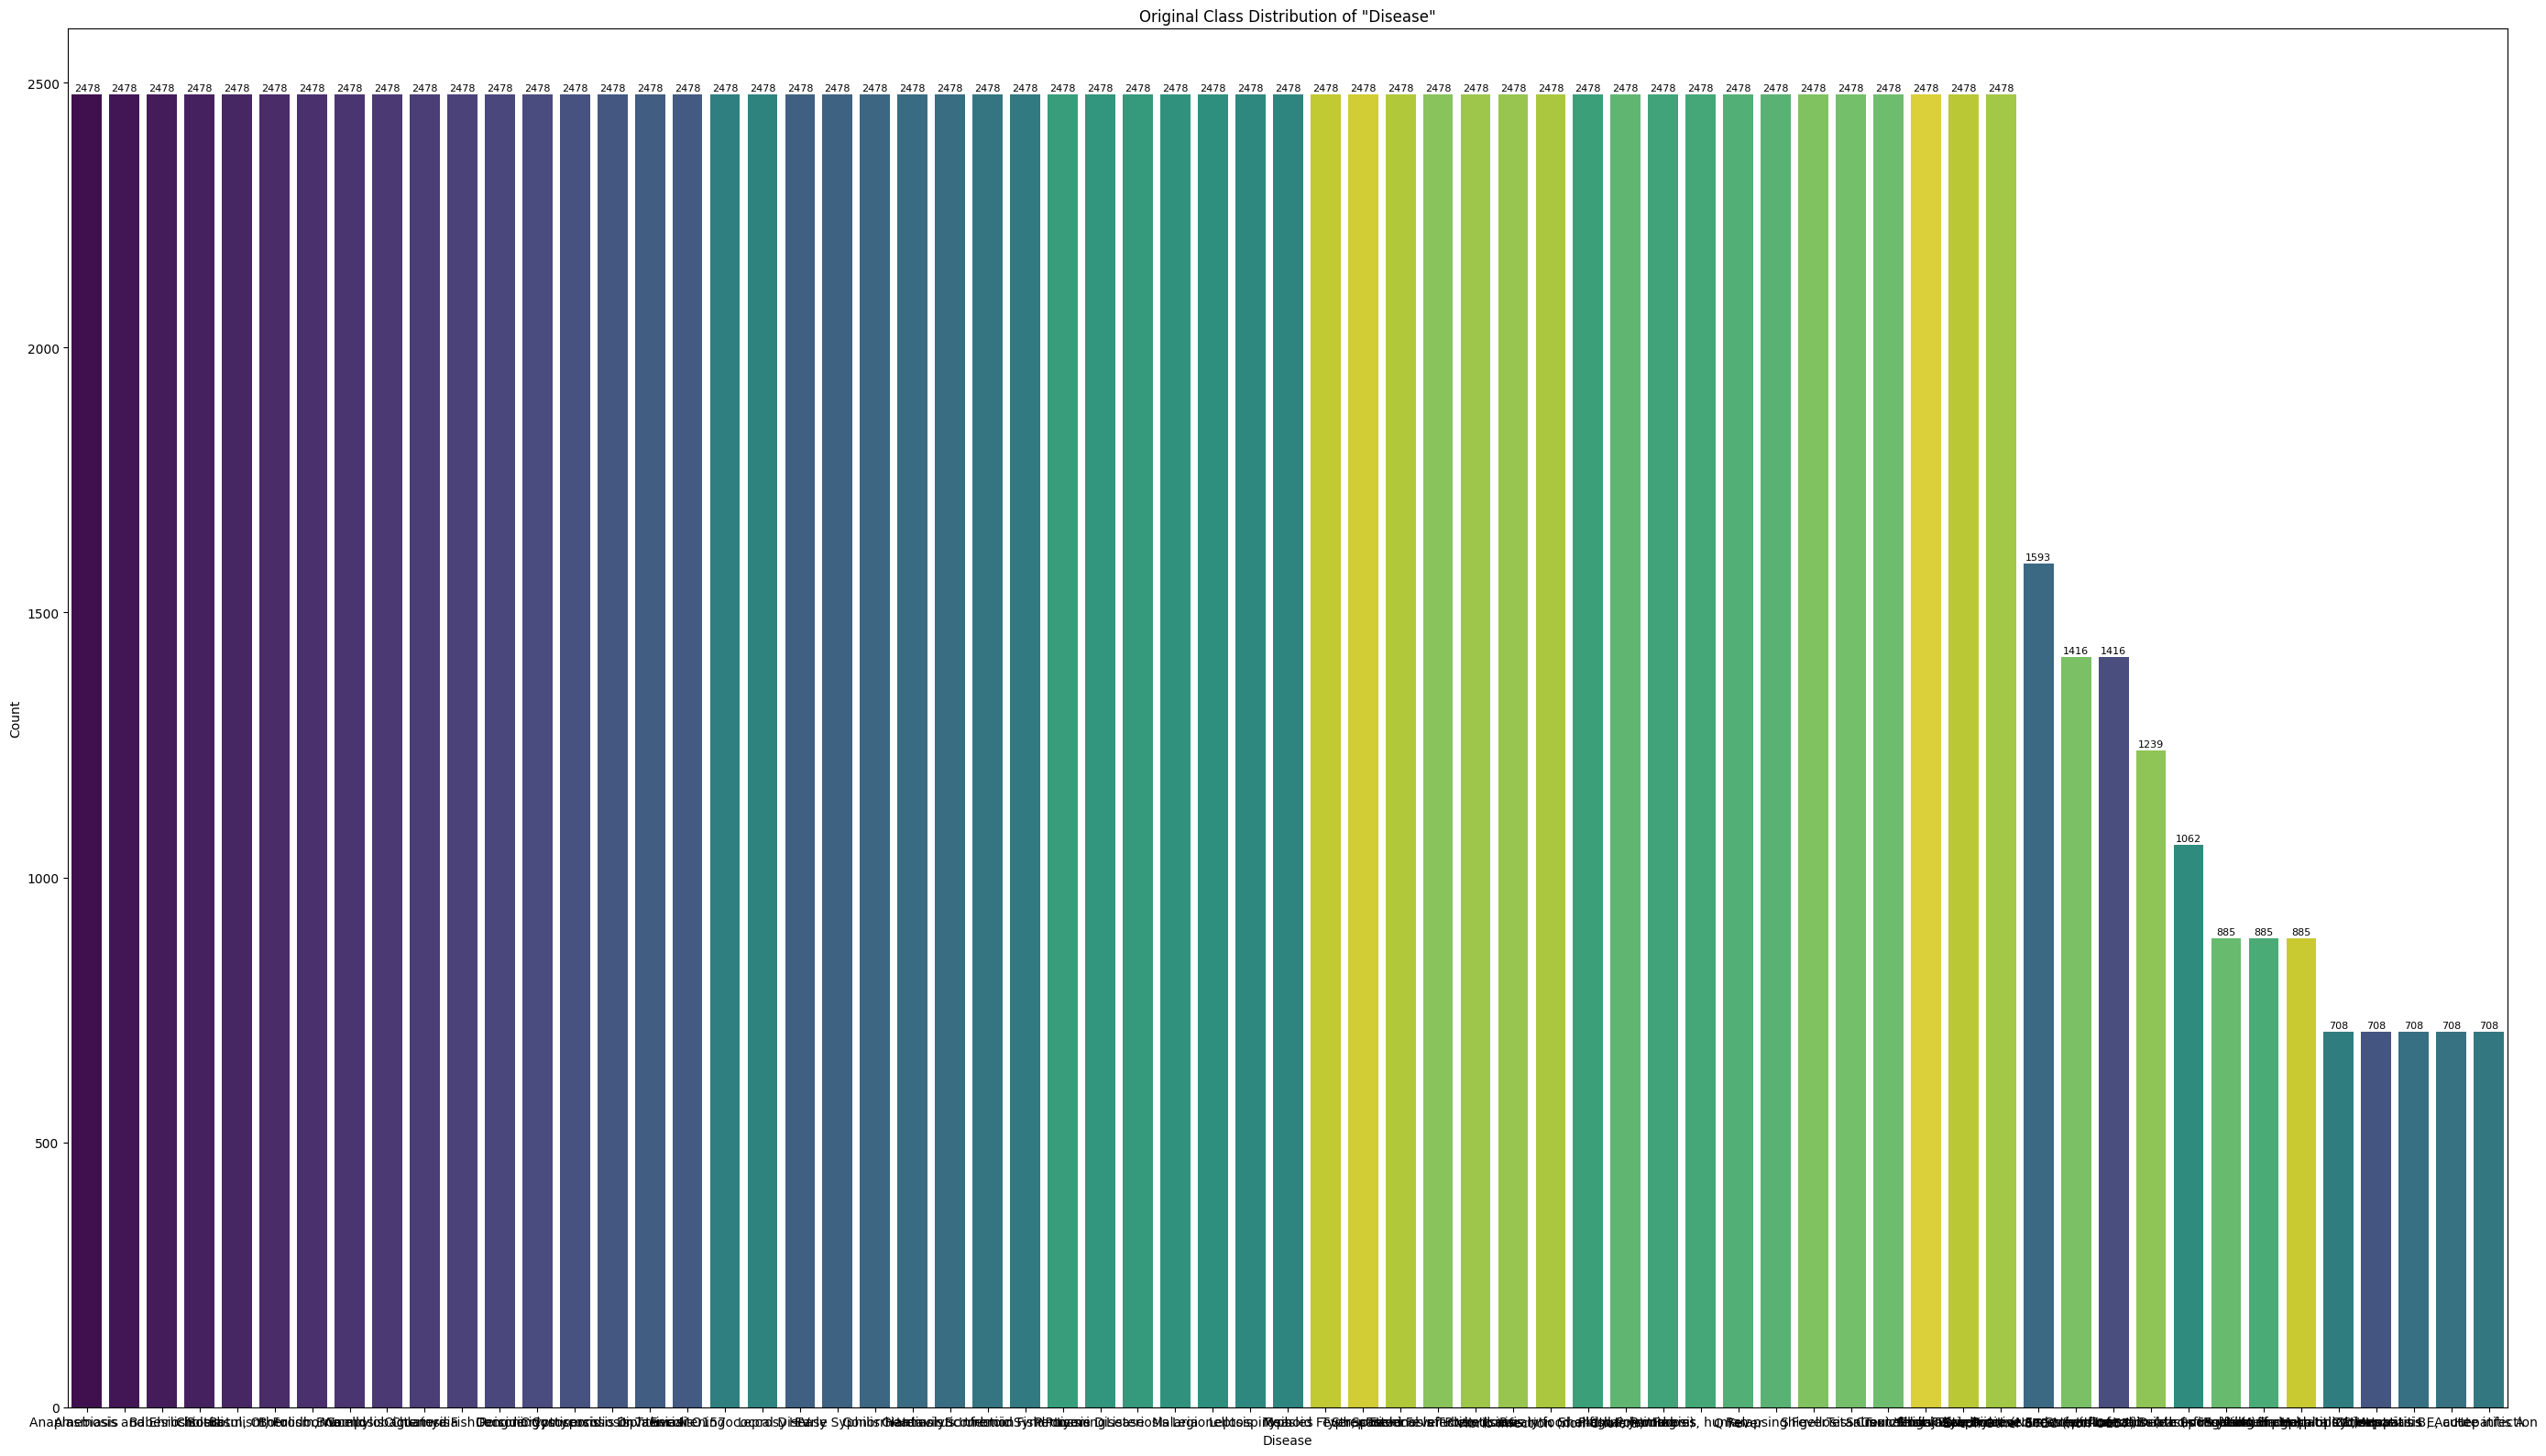


--- Resampled Class Distribution of 'Disease' ---


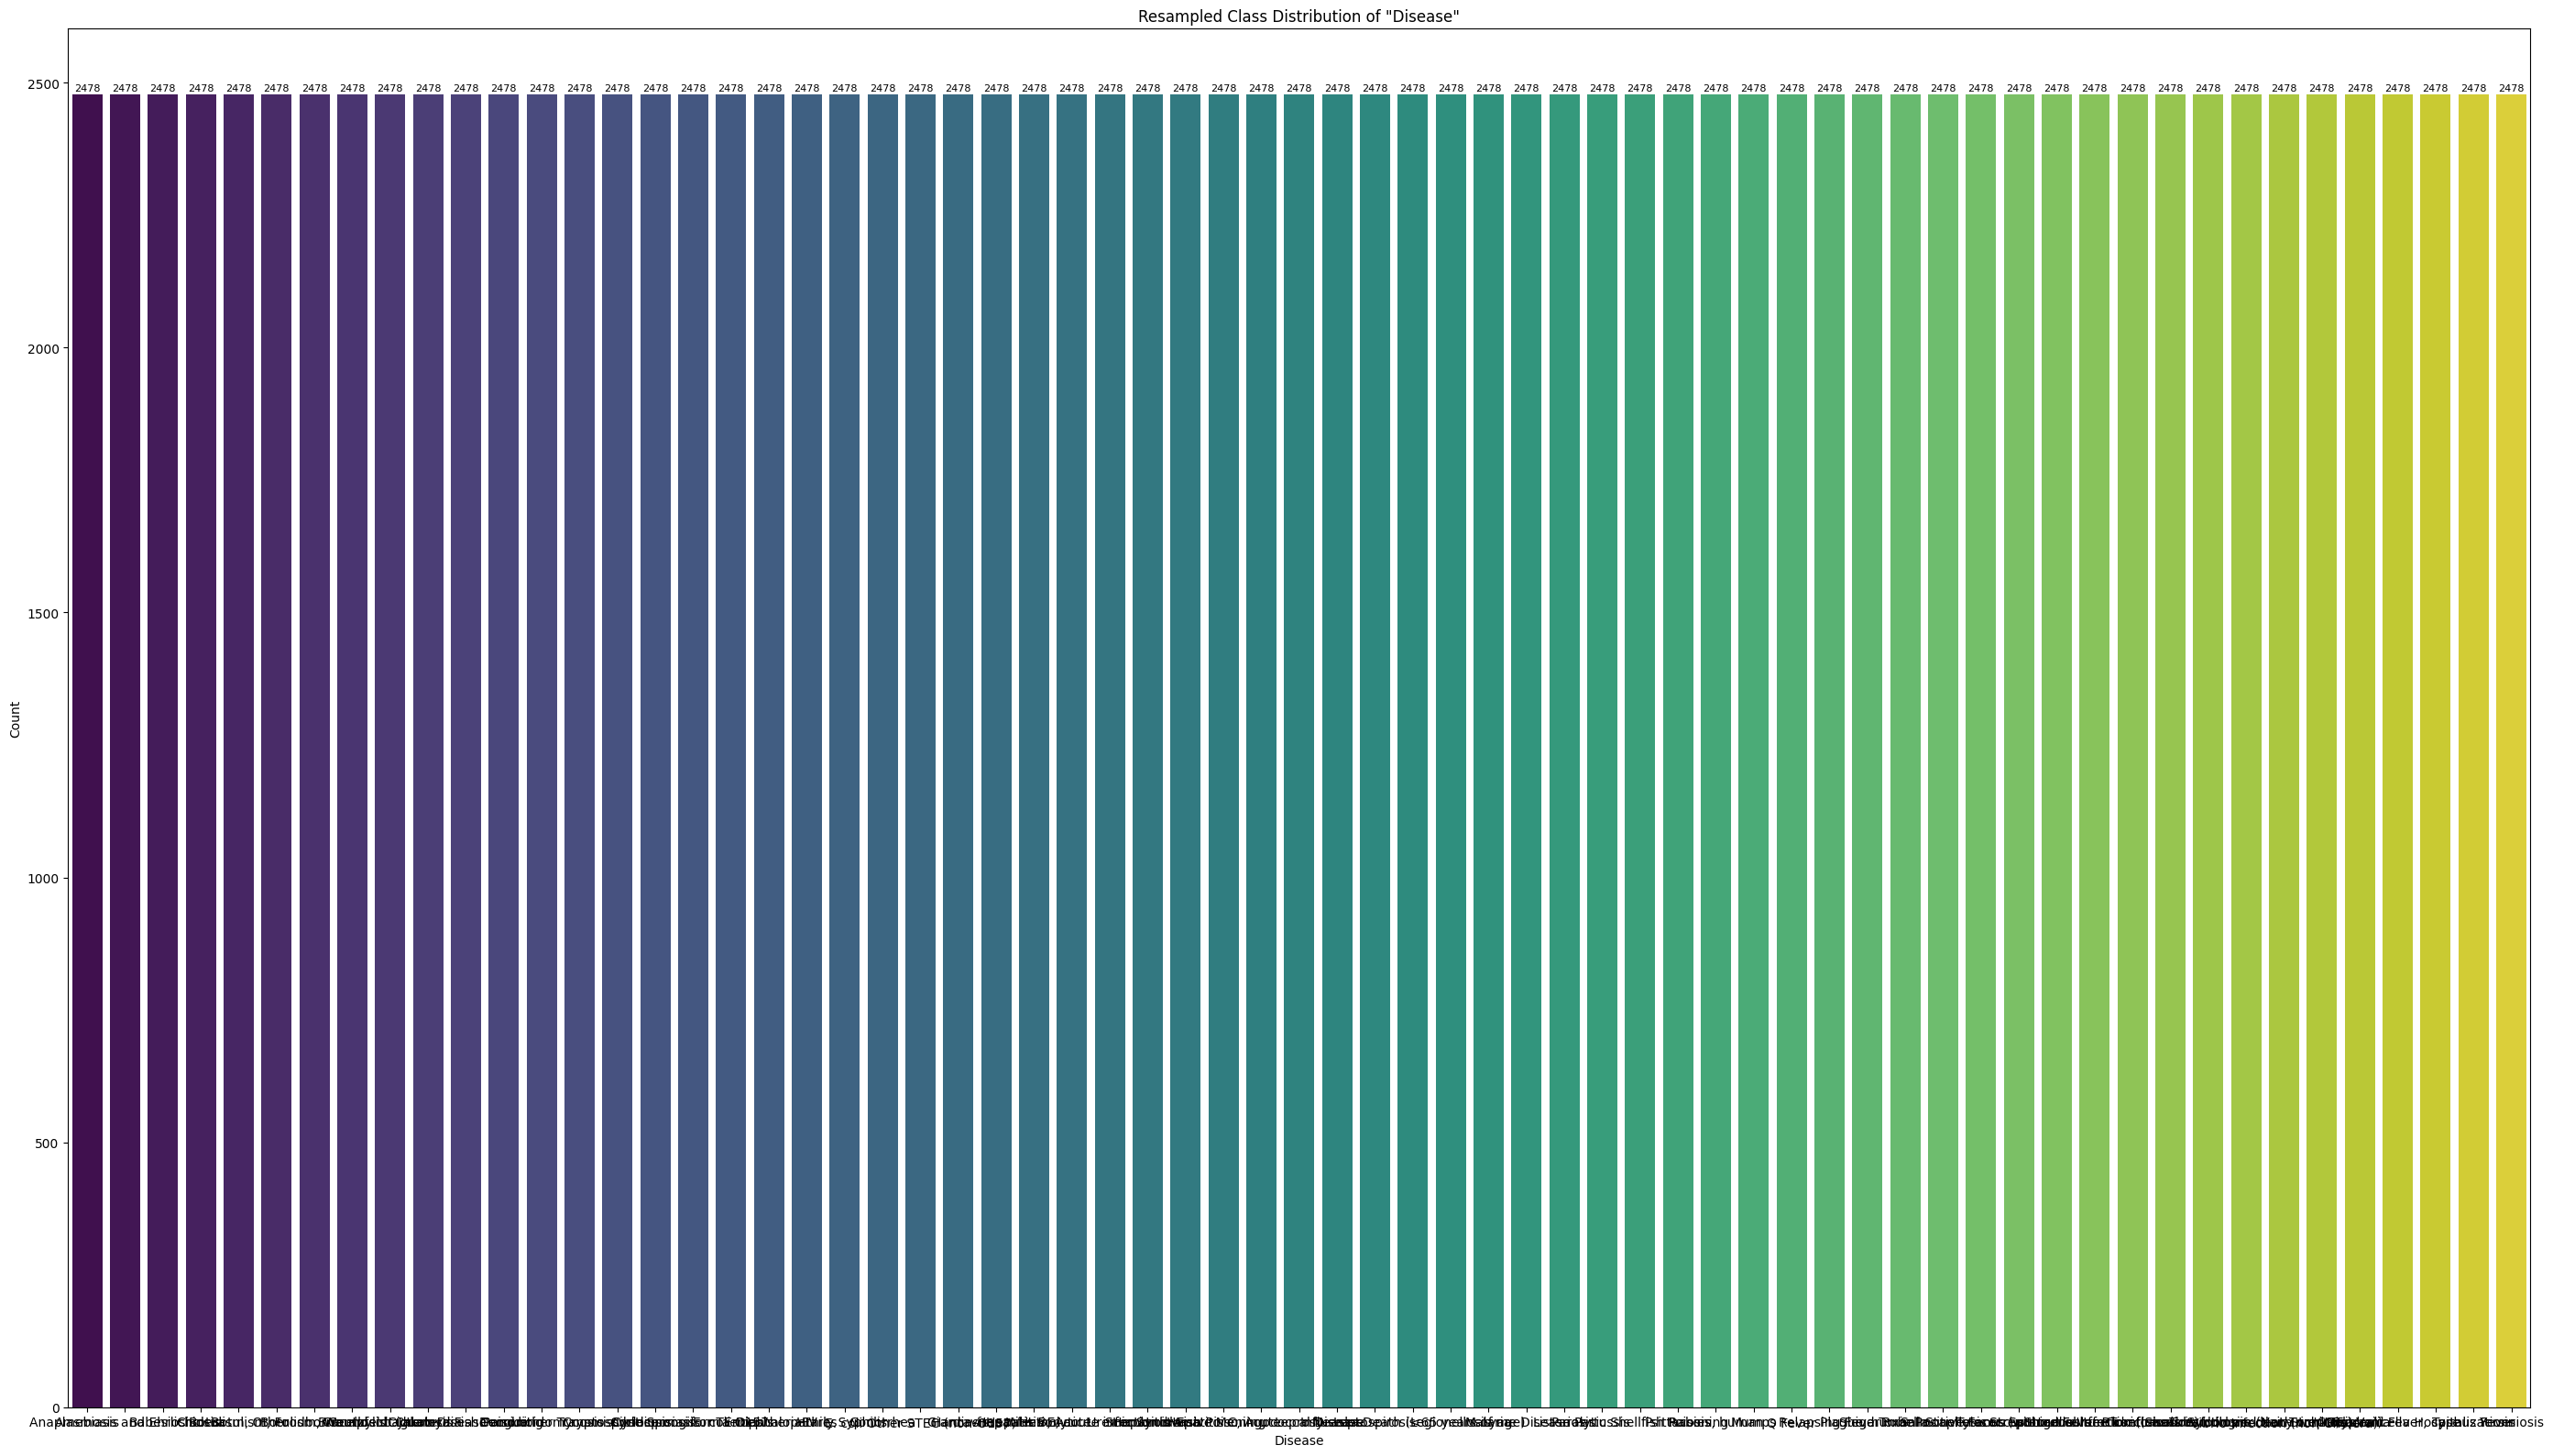

In [92]:
        print("\n--- Visualizing Class Distribution Before and After Balancing ---")

        # Visualize Original Class Distribution
        print(f"\n--- Original Class Distribution of '{target_column}' ---")
        plt.figure(figsize=(28, 16)) # Create a new figure for the original distribution
        sns.countplot(data=df, x=target_column, hue=target_column, palette='viridis',
                      order=y.value_counts().index, legend=False)
        plt.title(f'Original Class Distribution of "{target_column}"')
        plt.xlabel(target_column)
        plt.ylabel('Count')
        # Add value counts on top of bars
        ax_original = plt.gca() # Get current axes
        for p in ax_original.patches:
            ax_original.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')
        plt.tight_layout()
        plt.show() # Display the original distribution plot

        # Visualize Resampled Class Distribution
        print(f"\n--- Resampled Class Distribution of '{target_column}' ---")
        plt.figure(figsize=(28, 16)) # Create another new figure for the resampled distribution
        sns.countplot(data=df_balanced, x=target_column, hue=target_column, palette='viridis',
                      order=y_resampled.value_counts().index, legend=False)
        plt.title(f'Resampled Class Distribution of "{target_column}"')
        plt.xlabel(target_column)
        plt.ylabel('Count')
        # Add value counts on top of bars
        ax_resampled = plt.gca() # Get current axes
        for p in ax_resampled.patches:
            ax_resampled.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')
        plt.tight_layout()
        plt.show() # Display the resampled distribution plot


In [94]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if target_column in numerical_cols:
    numerical_cols.remove(target_column)
if target_column in categorical_cols:
    categorical_cols.remove(target_column)
def get_first_n(lst, n):
    return lst[:min(len(lst), n)]


 Univariate Distributions (Numerical Features) ---

 Histograms of Numerical Features


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col].dropna(), kde=True, bins=30, palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col].dropna(), kde=True, bins=30, palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col].dropna(), kde=True, bins=30, palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col].dropna(), kde=True, bins=30, palette='viridis')


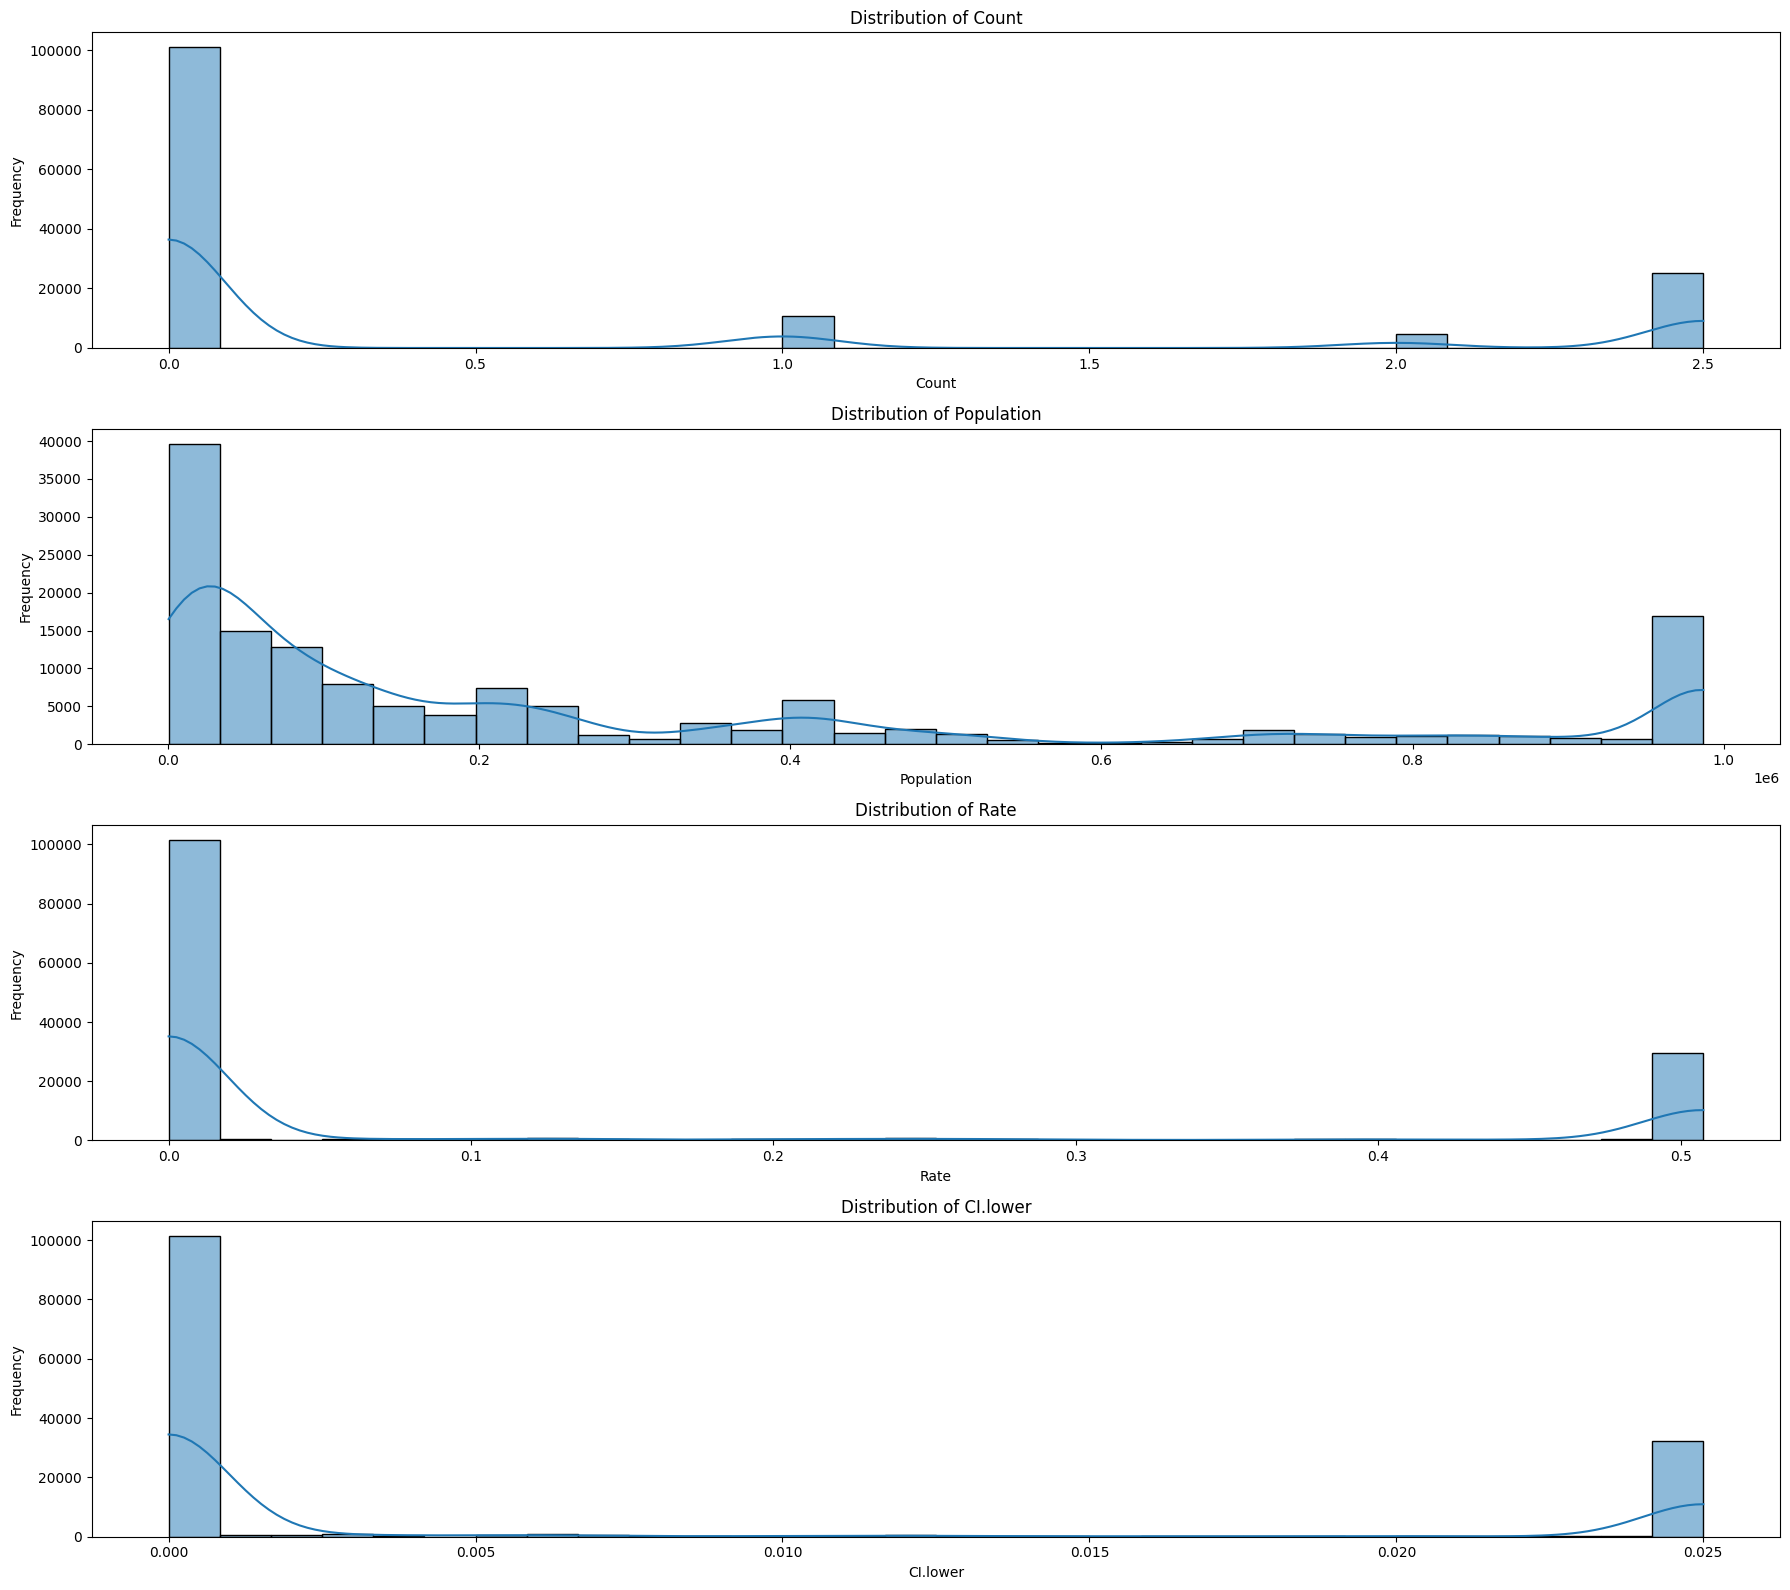


 KDE Plots of Numerical Features


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[col].dropna(), fill=True, palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[col].dropna(), fill=True, palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[col].dropna(), fill=True, palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df[col].dropna(), fill=True, palette='viridis')


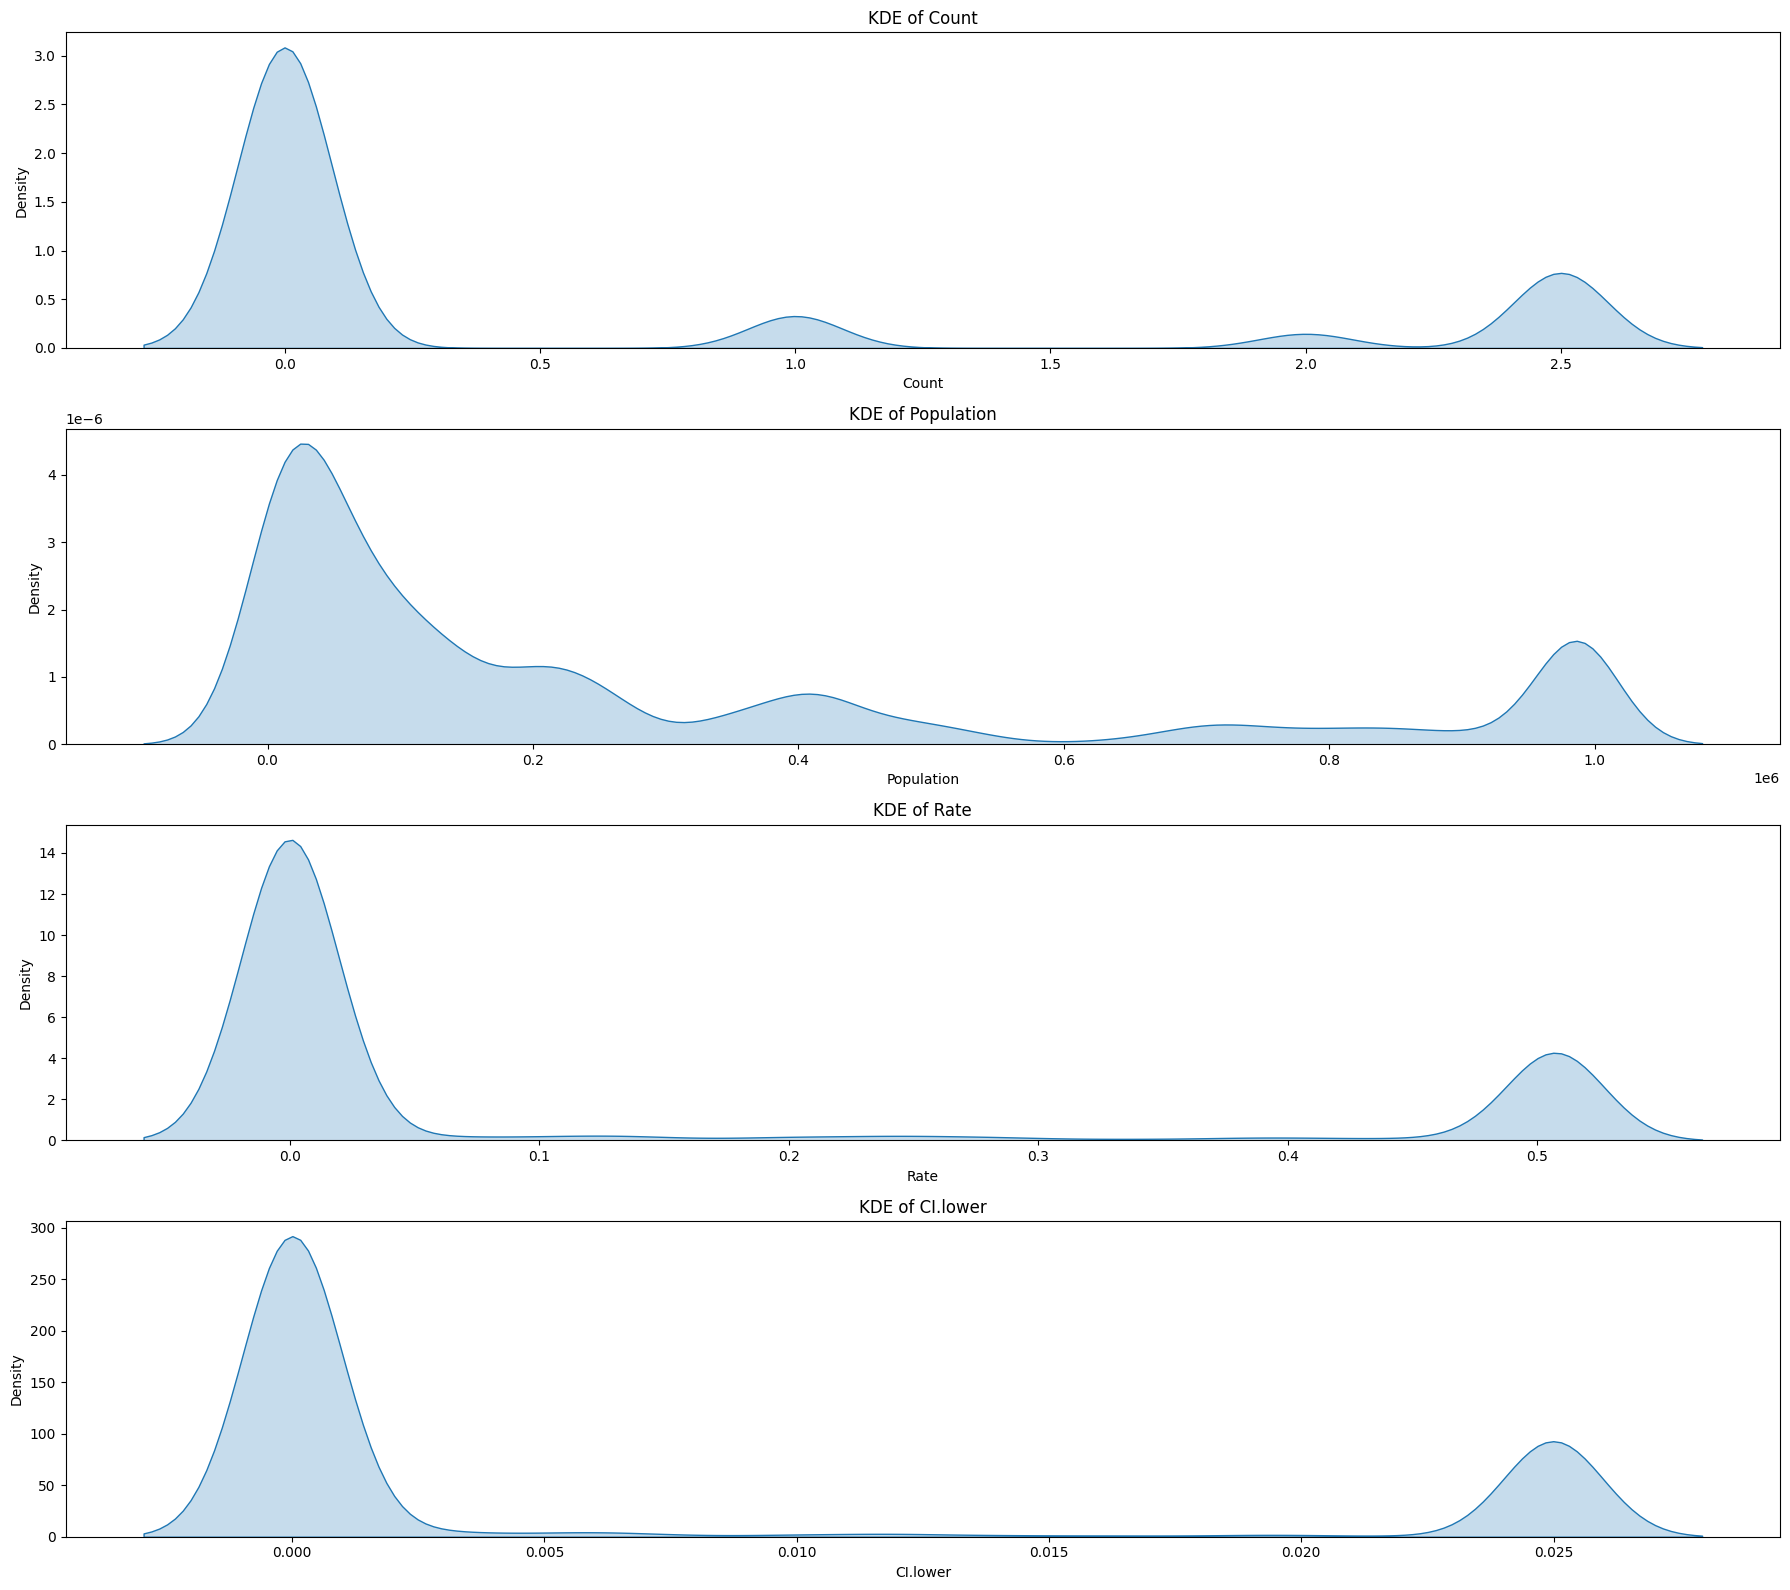


 Box Plots of Numerical Features


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col].dropna(), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col].dropna(), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col].dropna(), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:35: FutureWarning: 

Passing

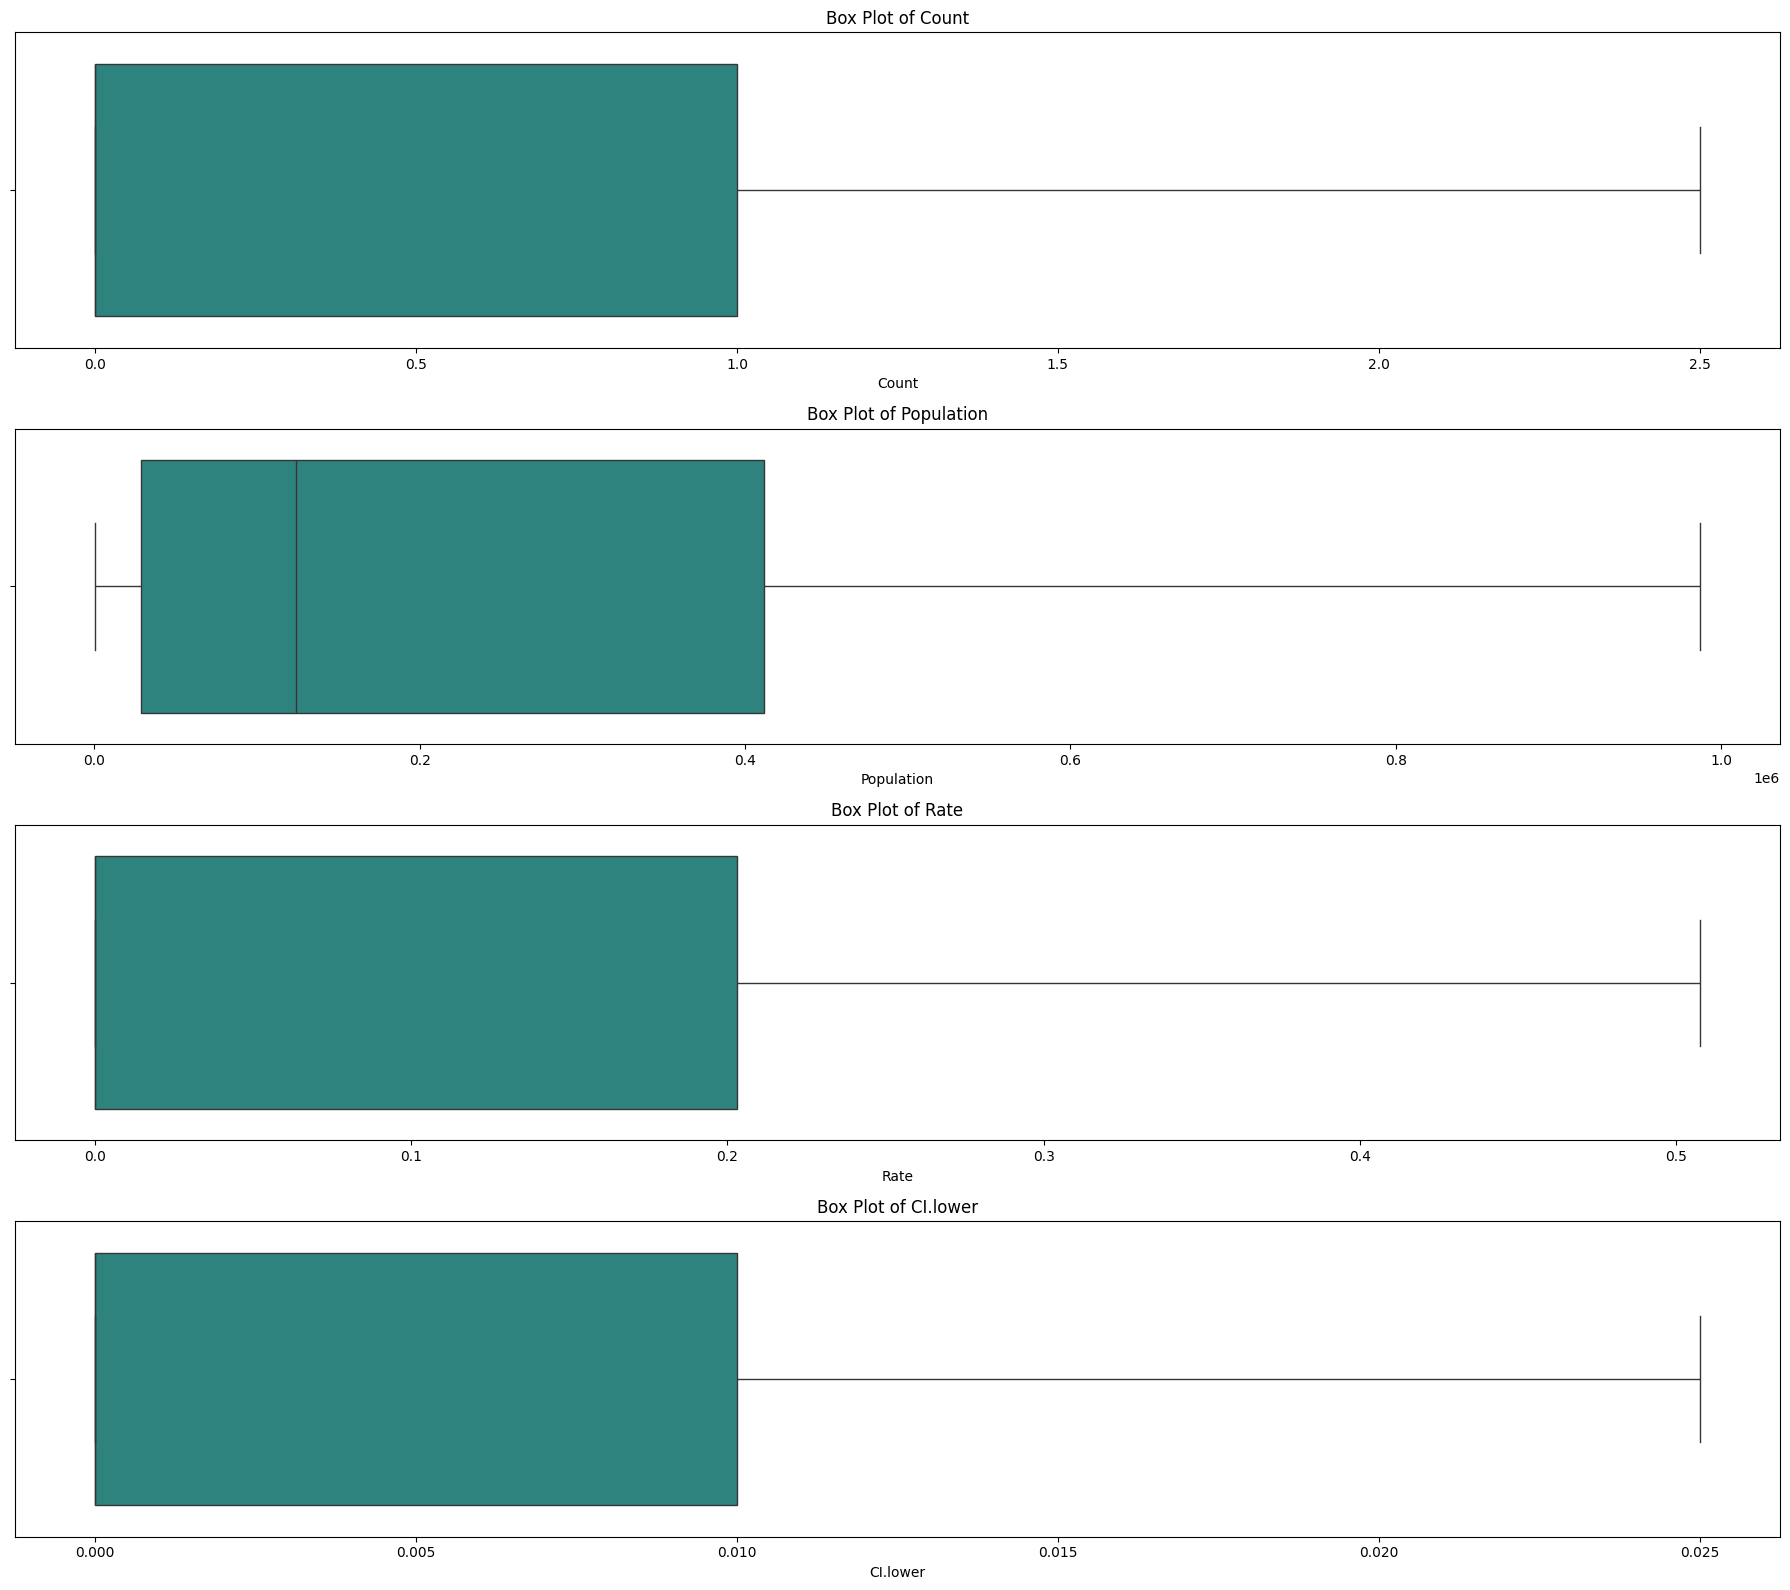


 Violin Plots of Numerical Features


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df[col].dropna(), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df[col].dropna(), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df[col].dropna(), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_28872\2027051248.py:46: FutureWarning: 

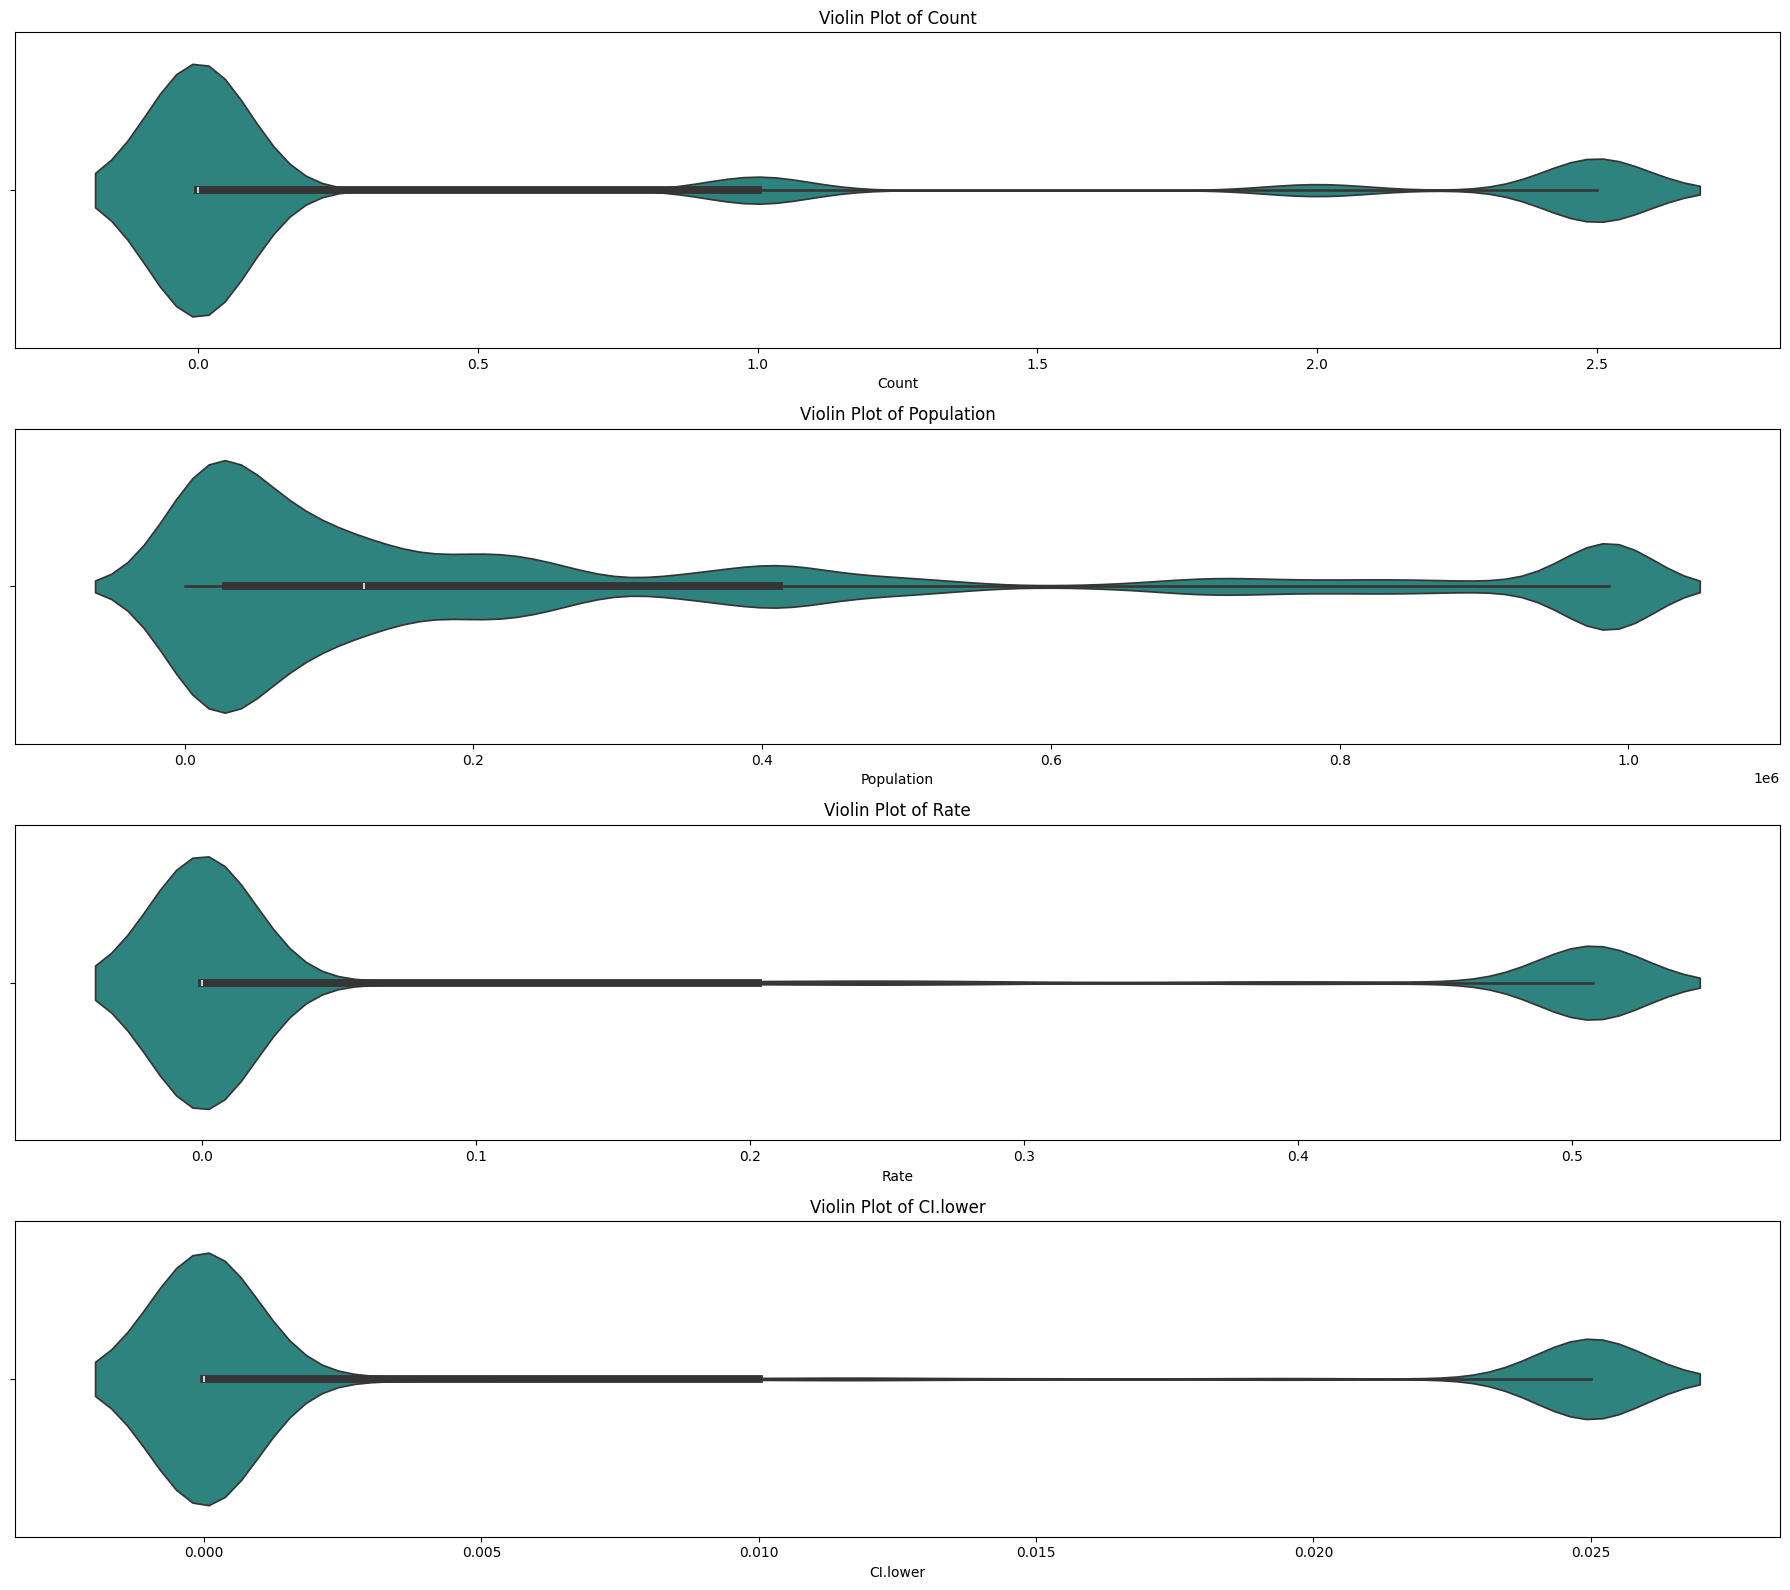

In [95]:
# Univariate Distributions (Numerical Features) ---
print("\n Univariate Distributions (Numerical Features) ---")
num_features_to_plot = get_first_n(numerical_cols, 4) # Select up to 4 numerical features for these plots

if num_features_to_plot:
    # 1. Histograms with KDE
    print("\n Histograms of Numerical Features")
    plt.figure(figsize=(18, 4 * len(num_features_to_plot)))
    for i, col in enumerate(num_features_to_plot):
        plt.subplot(len(num_features_to_plot), 1, i + 1)
        sns.histplot(df[col].dropna(), kde=True, bins=30, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
    plt.show()

    # KDE Plots (separate for clarity)
    print("\n KDE Plots of Numerical Features")
    plt.figure(figsize=(18, 4 * len(num_features_to_plot)))
    for i, col in enumerate(num_features_to_plot):
        plt.subplot(len(num_features_to_plot), 1, i + 1)
        sns.kdeplot(df[col].dropna(), fill=True, palette='viridis')
        plt.title(f'KDE of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.tight_layout()
    plt.show()

    # Box Plots
    print("\n Box Plots of Numerical Features")
    plt.figure(figsize=(18, 4 * len(num_features_to_plot)))
    for i, col in enumerate(num_features_to_plot):
        plt.subplot(len(num_features_to_plot), 1, i + 1)
        sns.boxplot(x=df[col].dropna(), palette='viridis')
        plt.title(f'Box Plot of {col}')
        plt.xlabel(col)
        plt.tight_layout()
    plt.show()

    # Violin Plots
    print("\n Violin Plots of Numerical Features")
    plt.figure(figsize=(18, 4 * len(num_features_to_plot)))
    for i, col in enumerate(num_features_to_plot):
        plt.subplot(len(num_features_to_plot), 1, i + 1)
        sns.violinplot(x=df[col].dropna(), palette='viridis')
        plt.title(f'Violin Plot of {col}')
        plt.xlabel(col)
        plt.tight_layout()
    plt.show()
else:
    print("No numerical features found for univariate plotting (excluding target).")


 Count Plots of Categorical Features


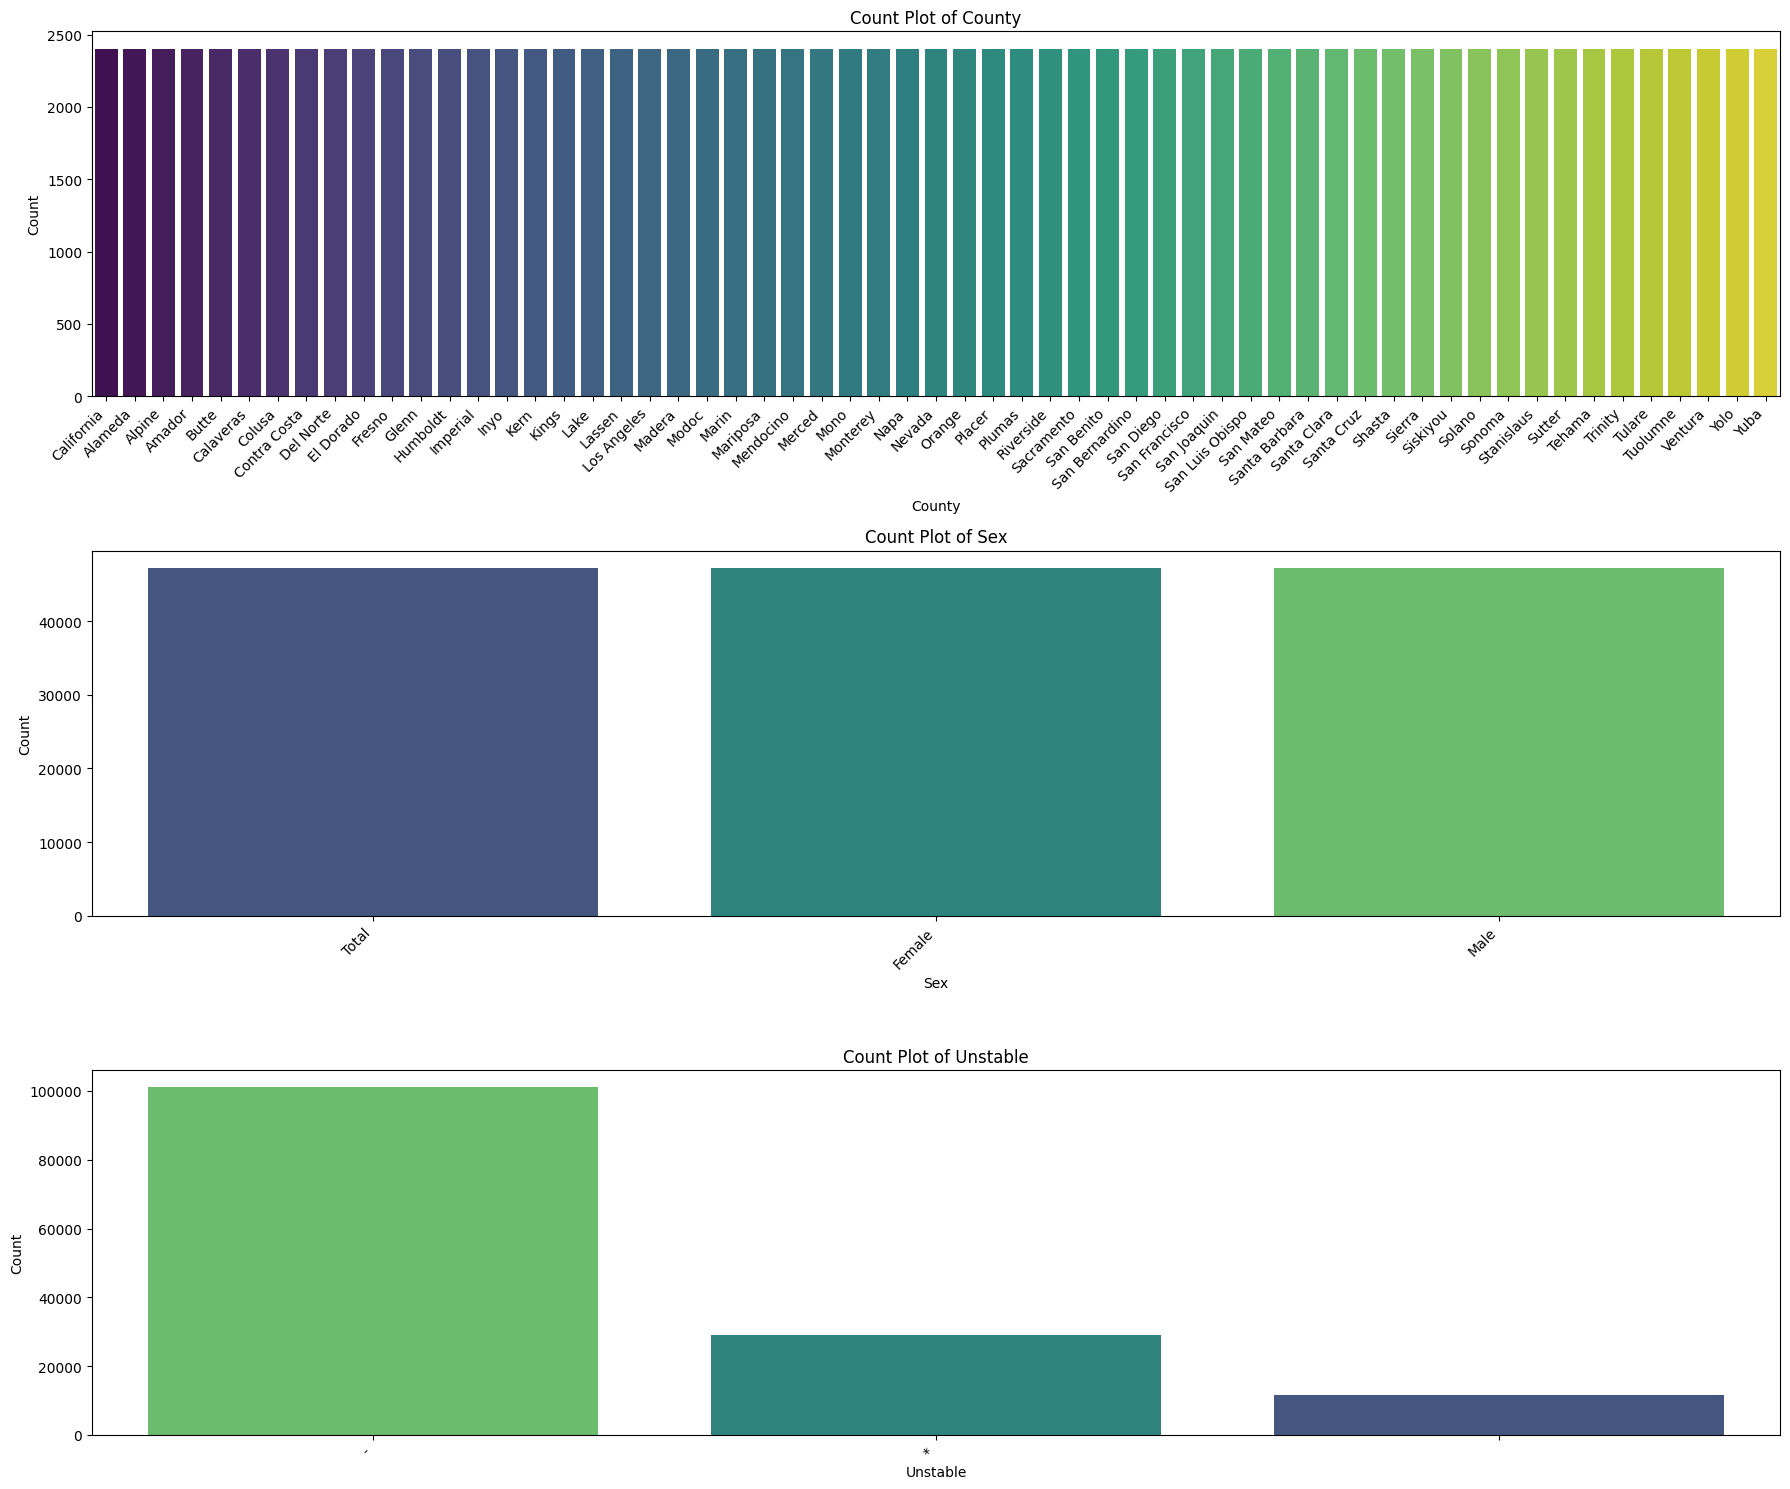


 Pie Charts of Categorical Features (if few categories)
Skipping pie chart for 'County' as it has too many unique values (59) or only one unique value.


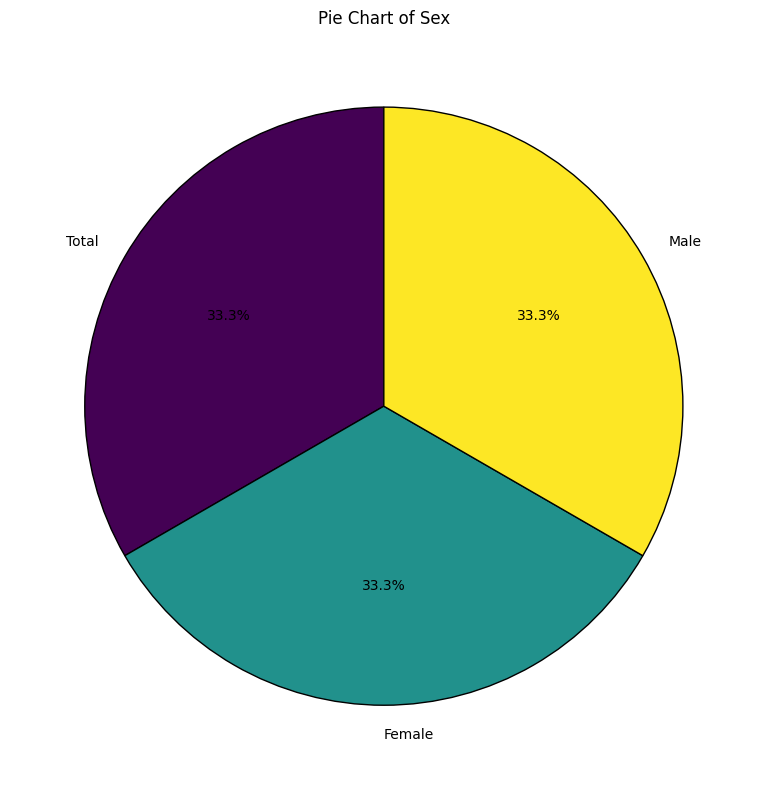

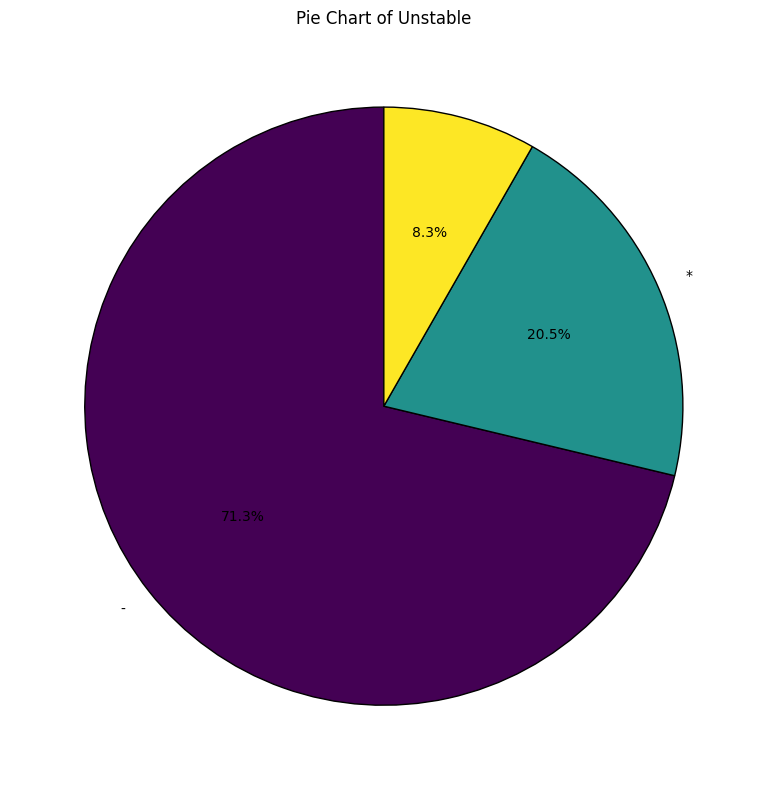

In [96]:
# Univariate Distributions (Categorical Features) ---
cat_features_to_plot = get_first_n(categorical_cols, 4) # Select up to 4 categorical features

if cat_features_to_plot:
    # Count Plots
    print("\n Count Plots of Categorical Features")
    plt.figure(figsize=(18, 5 * len(cat_features_to_plot)))
    for i, col in enumerate(cat_features_to_plot):
        plt.subplot(len(cat_features_to_plot), 1, i + 1)
        sns.countplot(data=df, x=col, hue=col, palette='viridis', legend=False,
                      order=df[col].value_counts().index)
        plt.title(f'Count Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    plt.show()

    #  Pie Charts (for features with few unique values)
    print("\n Pie Charts of Categorical Features (if few categories)")
    for col in cat_features_to_plot:
        if df[col].nunique() <= 7 and df[col].nunique() > 1: # Limit pie charts to features with 2-7 unique values
            plt.figure(figsize=(8, 8))
            df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis',
                                            wedgeprops={'edgecolor': 'black'})
            plt.title(f'Pie Chart of {col}')
            plt.ylabel('') # Hide the default 'count' label
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping pie chart for '{col}' as it has too many unique values ({df[col].nunique()}) or only one unique value.")
else:
    print("No categorical features found for univariate plotting (excluding target).")


 Correlation Heatmap of Numerical Features


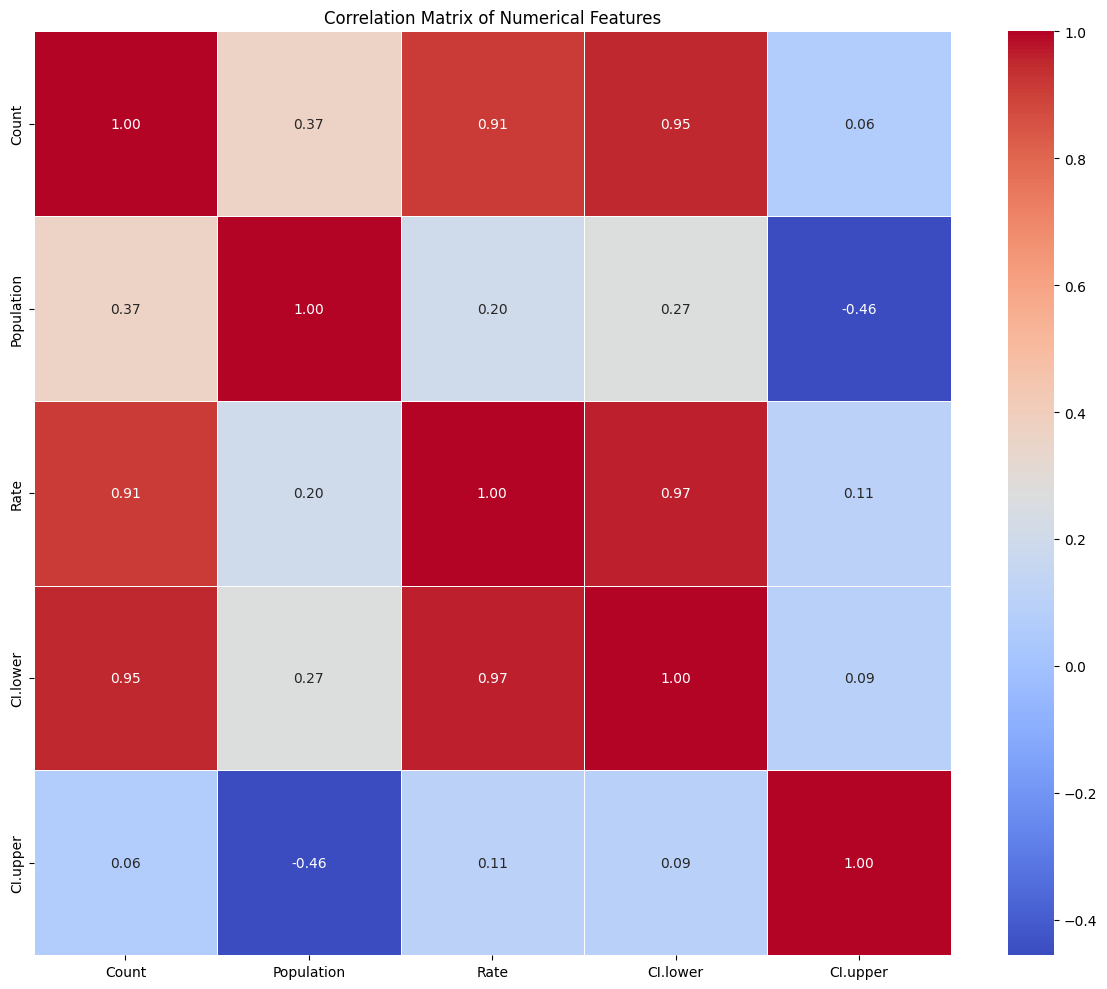


 Pair Plot (subset of numerical features)


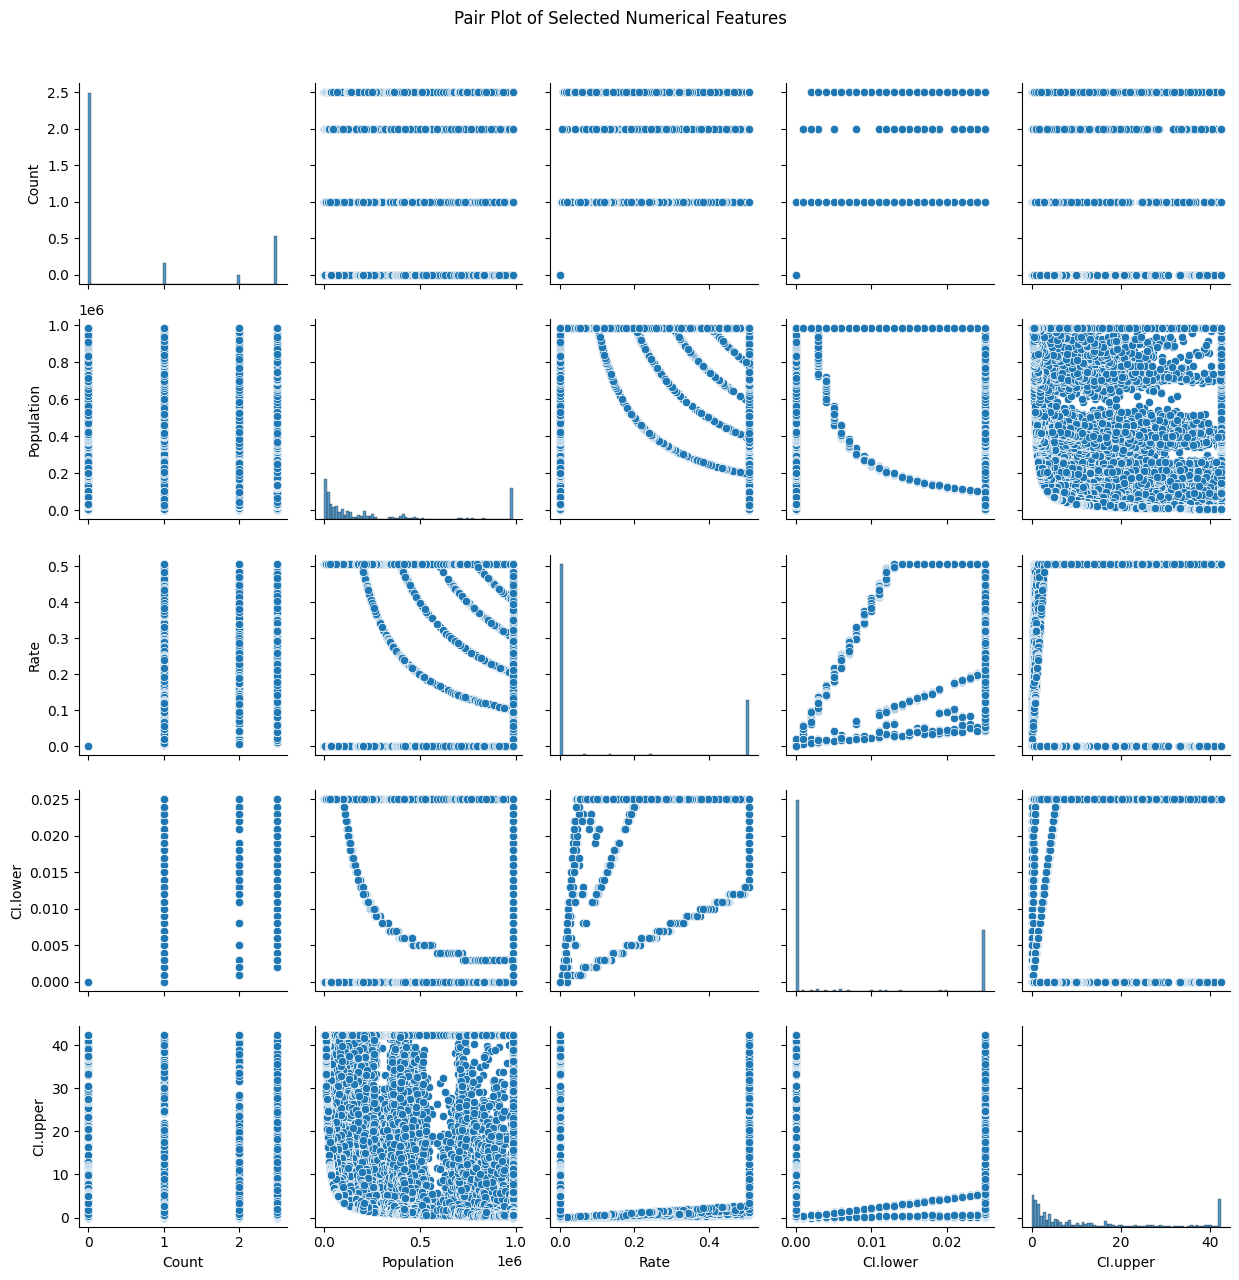

In [100]:
# Bivariate Relationships (Numerical vs. Numerical) ---
if len(numerical_cols) >= 2:
    #  Correlation Heatmap
    print("\n Correlation Heatmap of Numerical Features")
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

    # Pair Plot (subset for performance)
    print("\n Pair Plot (subset of numerical features)")
    pair_plot_cols = get_first_n(numerical_cols, 5) # Plot up to 5 numerical features for pair plot
    if len(pair_plot_cols) >= 2:
        sns.pairplot(df[pair_plot_cols])
        plt.suptitle('Pair Plot of Selected Numerical Features', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numerical features for a pair plot (need at least 2).")




 Stacked Bar Chart: County vs. Sex


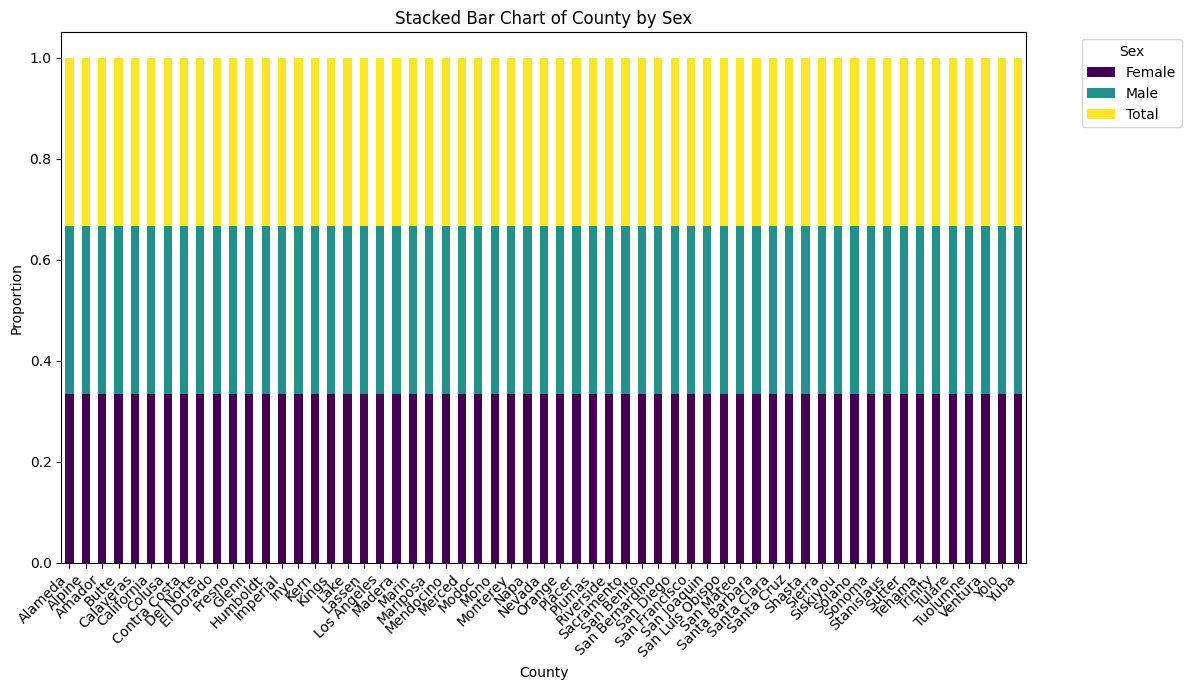


 Count Plot with Hue: County by Sex


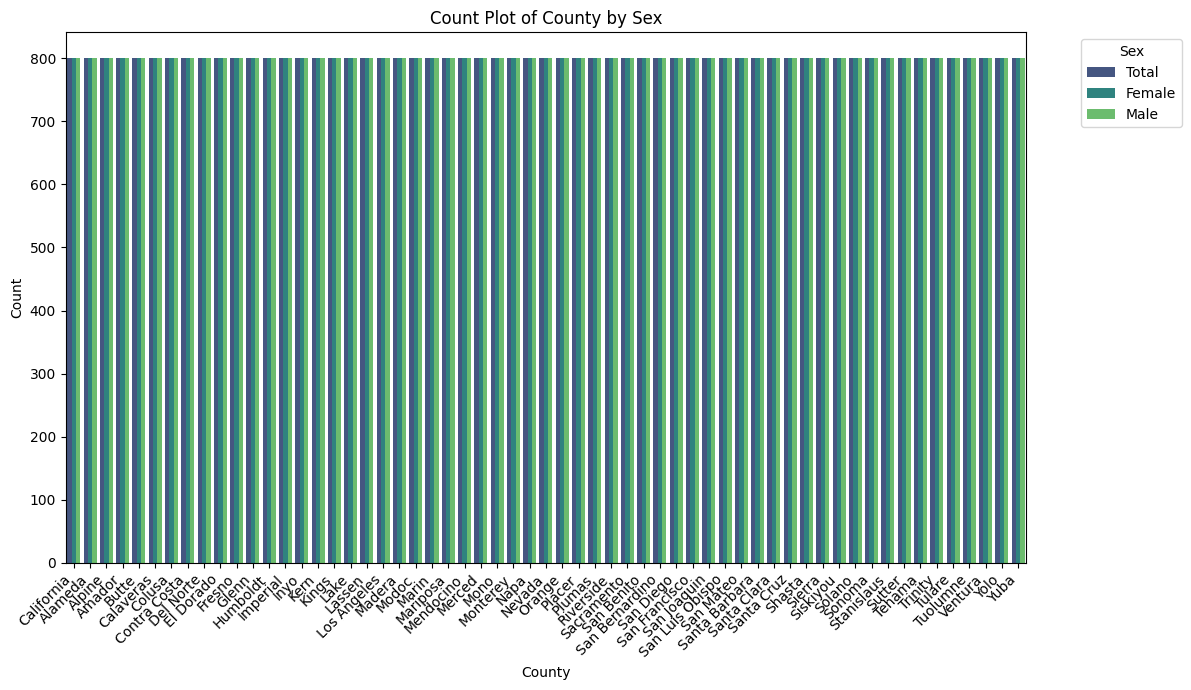

In [105]:
# Bivariate Relationships (Categorical vs. Categorical) ---

if len(categorical_cols) >= 2:
    cat_col1, cat_col2 = categorical_cols[0], categorical_cols[1]

    # Stacked Bar Chart of two key categorical features
    print(f"\n Stacked Bar Chart: {cat_col1} vs. {cat_col2}")
    cross_tab = pd.crosstab(df[cat_col1], df[cat_col2], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='viridis')
    plt.title(f'Stacked Bar Chart of {cat_col1} by {cat_col2}')
    plt.xlabel(cat_col1)
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=cat_col2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Count Plot with hue for two key categorical features
    print(f"\n Count Plot with Hue: {cat_col1} by {cat_col2}")
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=cat_col1, hue=cat_col2, palette='viridis',
                  order=df[cat_col1].value_counts().index)
    plt.title(f'Count Plot of {cat_col1} by {cat_col2}')
    plt.xlabel(cat_col1)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=cat_col2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough categorical features for bivariate categorical plotting (need at least 2).")


 Box Plot: Count by County


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\1661236992.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col_for_num, y=num_col_for_cat, palette='viridis',


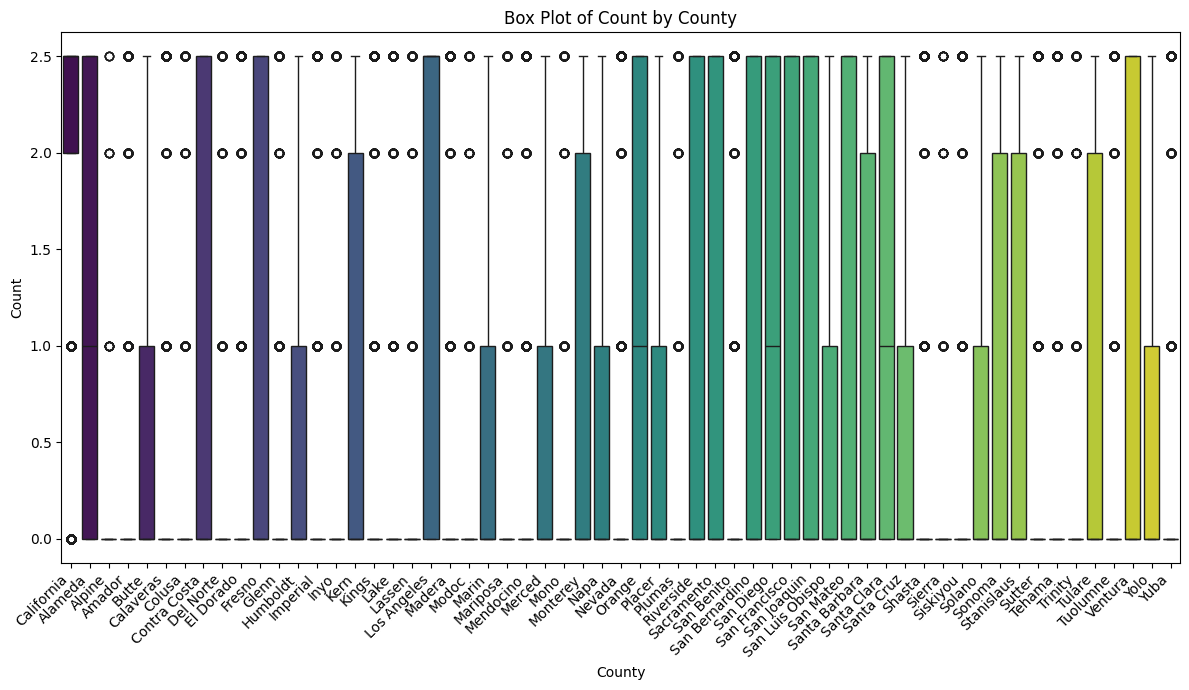


 Violin Plot: Count by County


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\1661236992.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=cat_col_for_num, y=num_col_for_cat, palette='viridis',


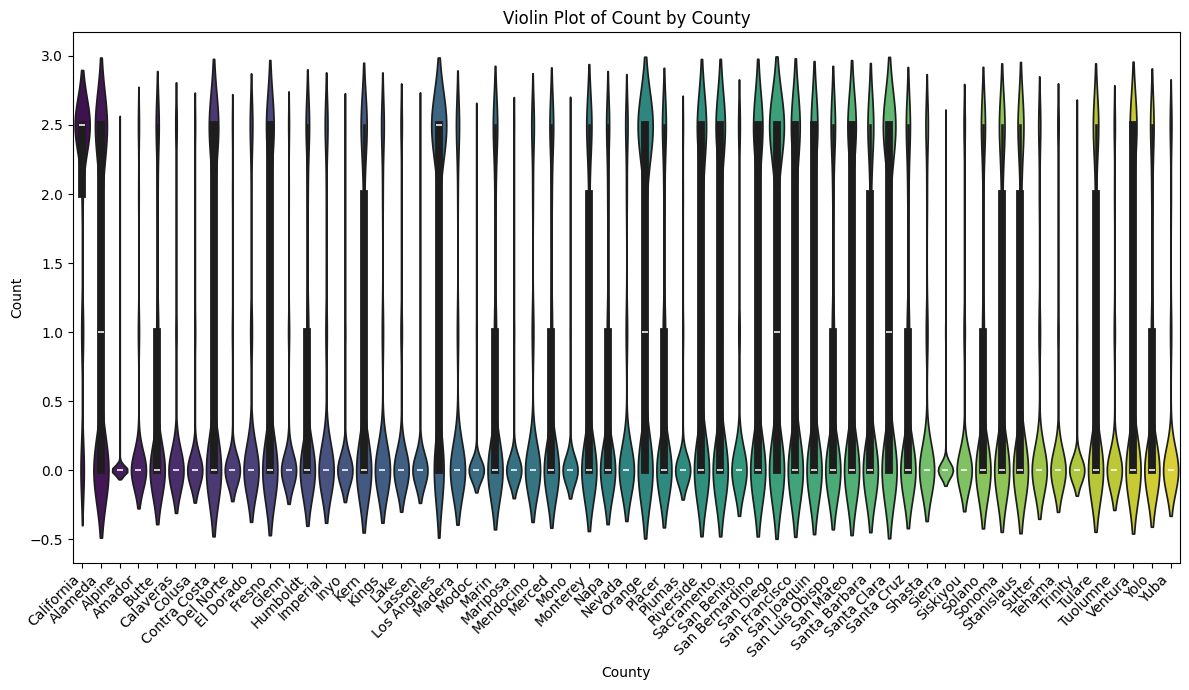

In [106]:
#  Bivariate Relationships (Numerical vs. Categorical) ---

if numerical_cols and categorical_cols:
    num_col_for_cat = numerical_cols[0]
    cat_col_for_num = categorical_cols[0]

    #  Box Plot of a numerical feature by a categorical feature
    print(f"\n Box Plot: {num_col_for_cat} by {cat_col_for_num}")
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df, x=cat_col_for_num, y=num_col_for_cat, palette='viridis',
                order=df[cat_col_for_num].value_counts().index)
    plt.title(f'Box Plot of {num_col_for_cat} by {cat_col_for_num}')
    plt.xlabel(cat_col_for_num)
    plt.ylabel(num_col_for_cat)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Violin Plot of a numerical feature by a categorical feature
    print(f"\n Violin Plot: {num_col_for_cat} by {cat_col_for_num}")
    plt.figure(figsize=(12, 7))
    sns.violinplot(data=df, x=cat_col_for_num, y=num_col_for_cat, palette='viridis',
                   order=df[cat_col_for_num].value_counts().index)
    plt.title(f'Violin Plot of {num_col_for_cat} by {cat_col_for_num}')
    plt.xlabel(cat_col_for_num)
    plt.ylabel(num_col_for_cat)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical and/or categorical features for bivariate plotting.")


 Box Plot: Count by Disease


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\3526732886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_column, y=num_col_for_target, palette='viridis')


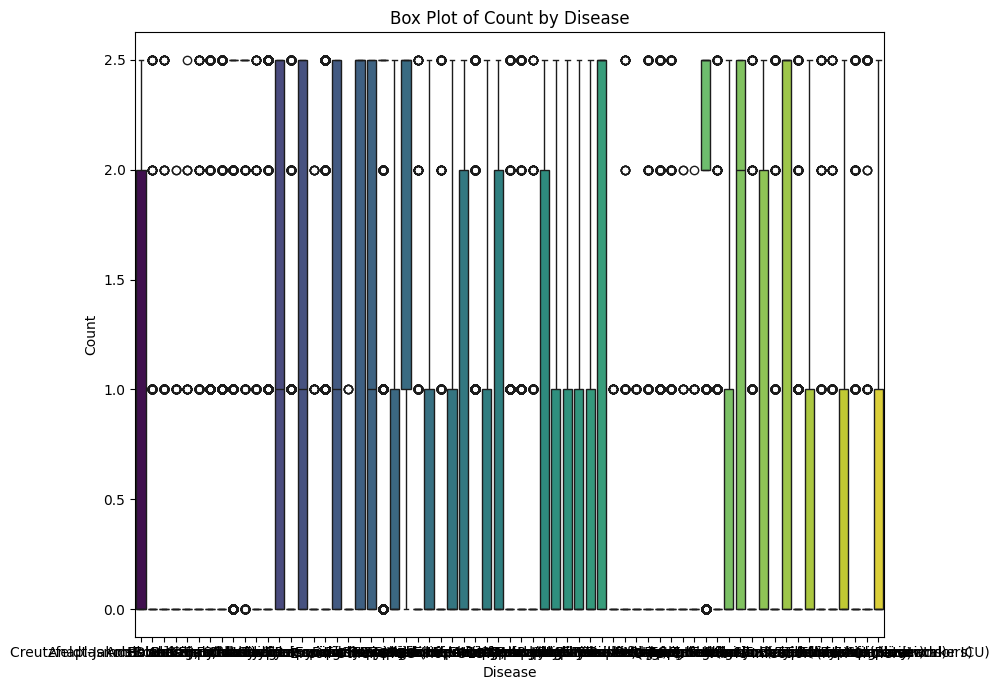


 Violin Plot: Count by Disease


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\3526732886.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=target_column, y=num_col_for_target, palette='viridis')


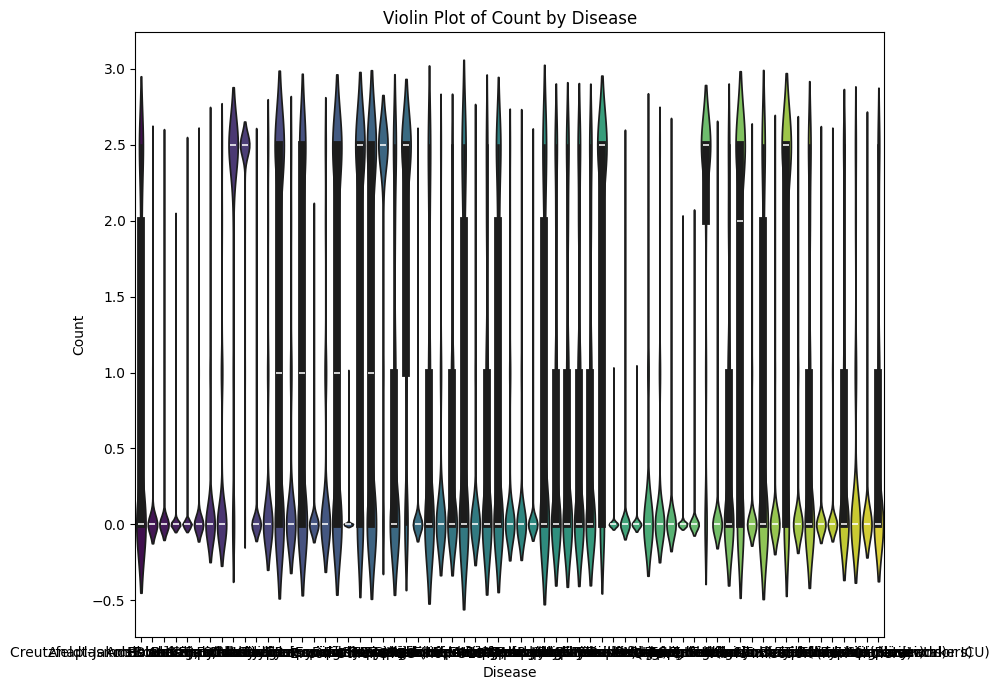


 Count Plot: County by Disease


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\3526732886.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


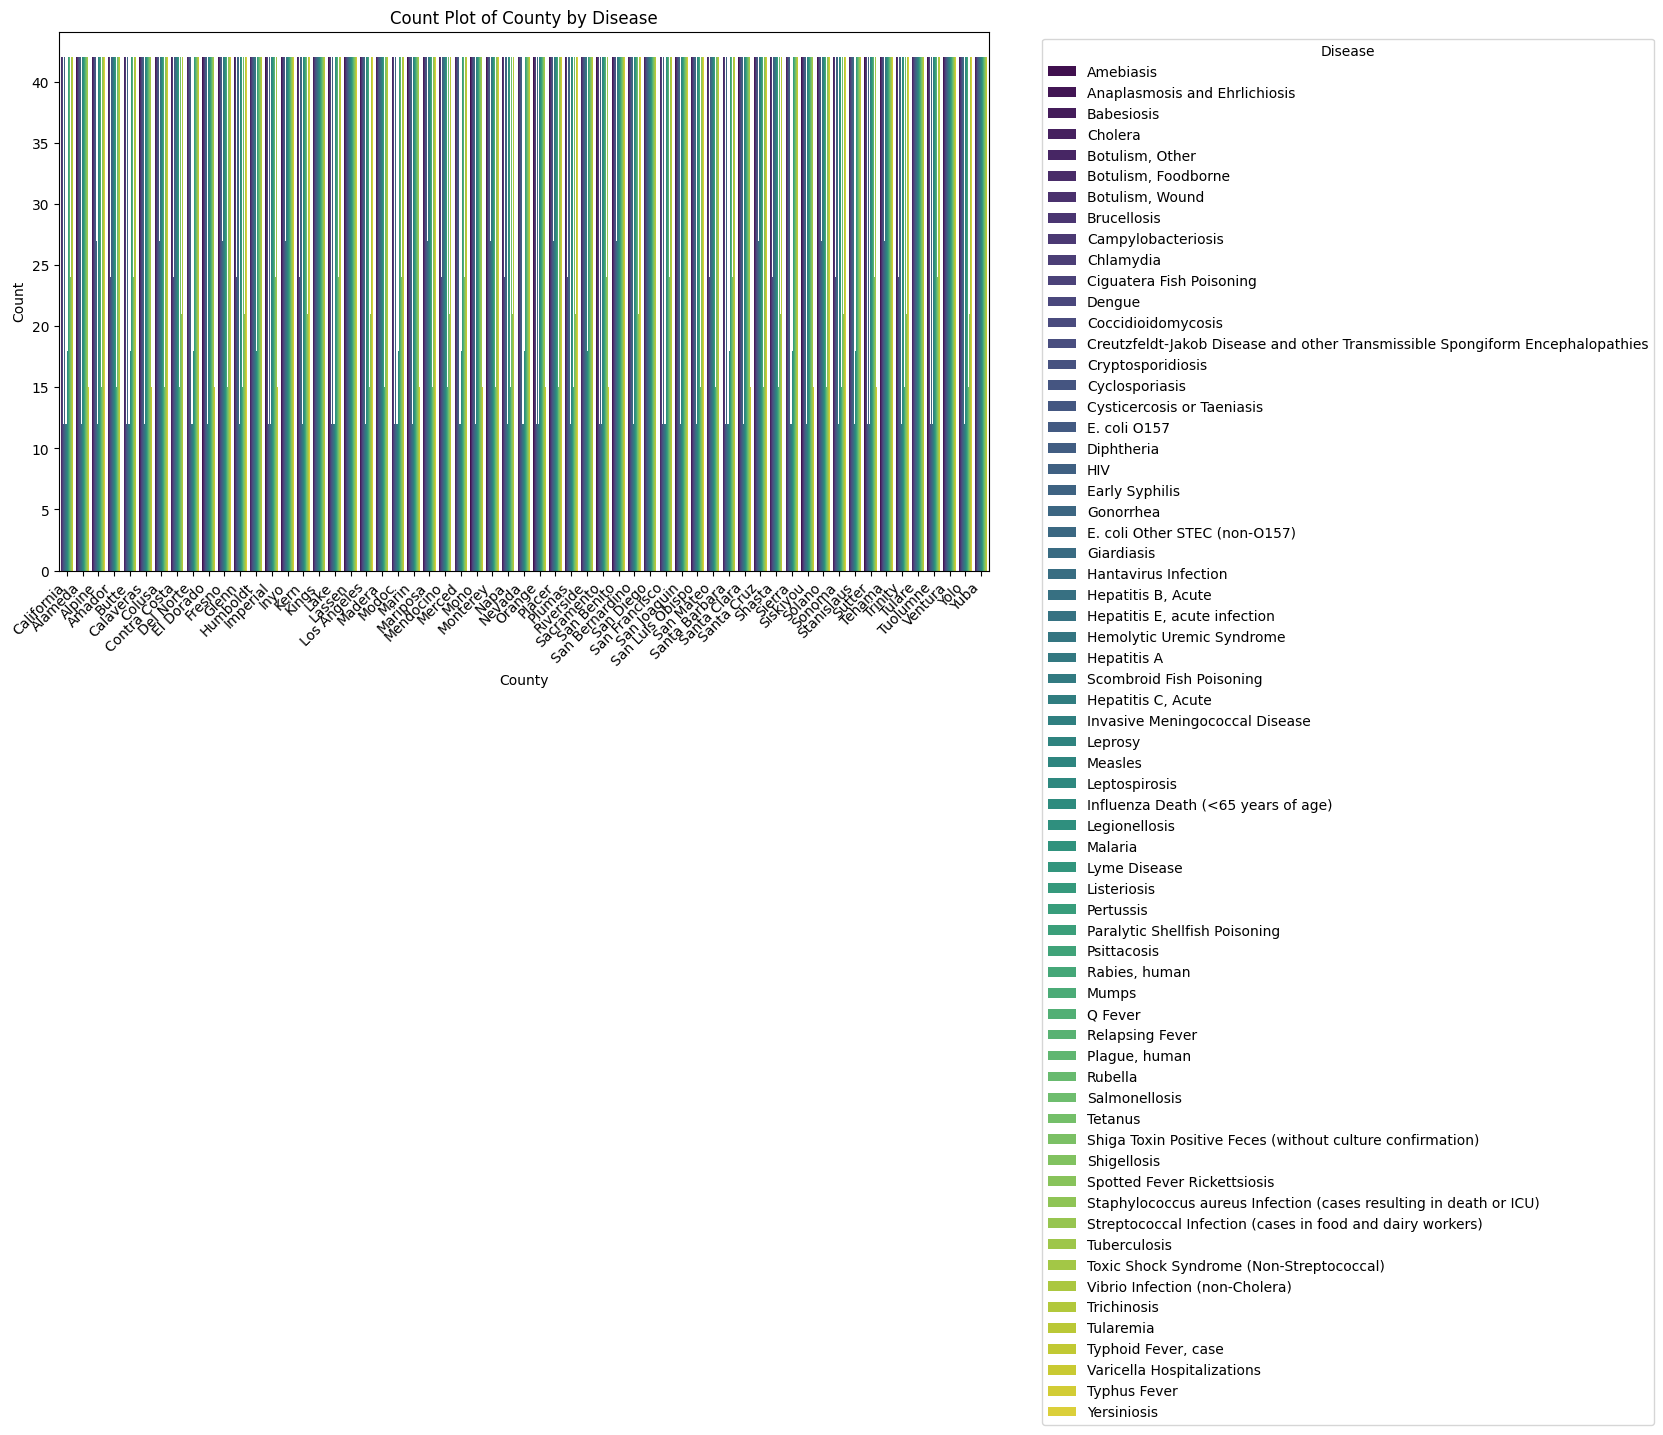


 Stacked Bar Chart: County by Disease


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\3526732886.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


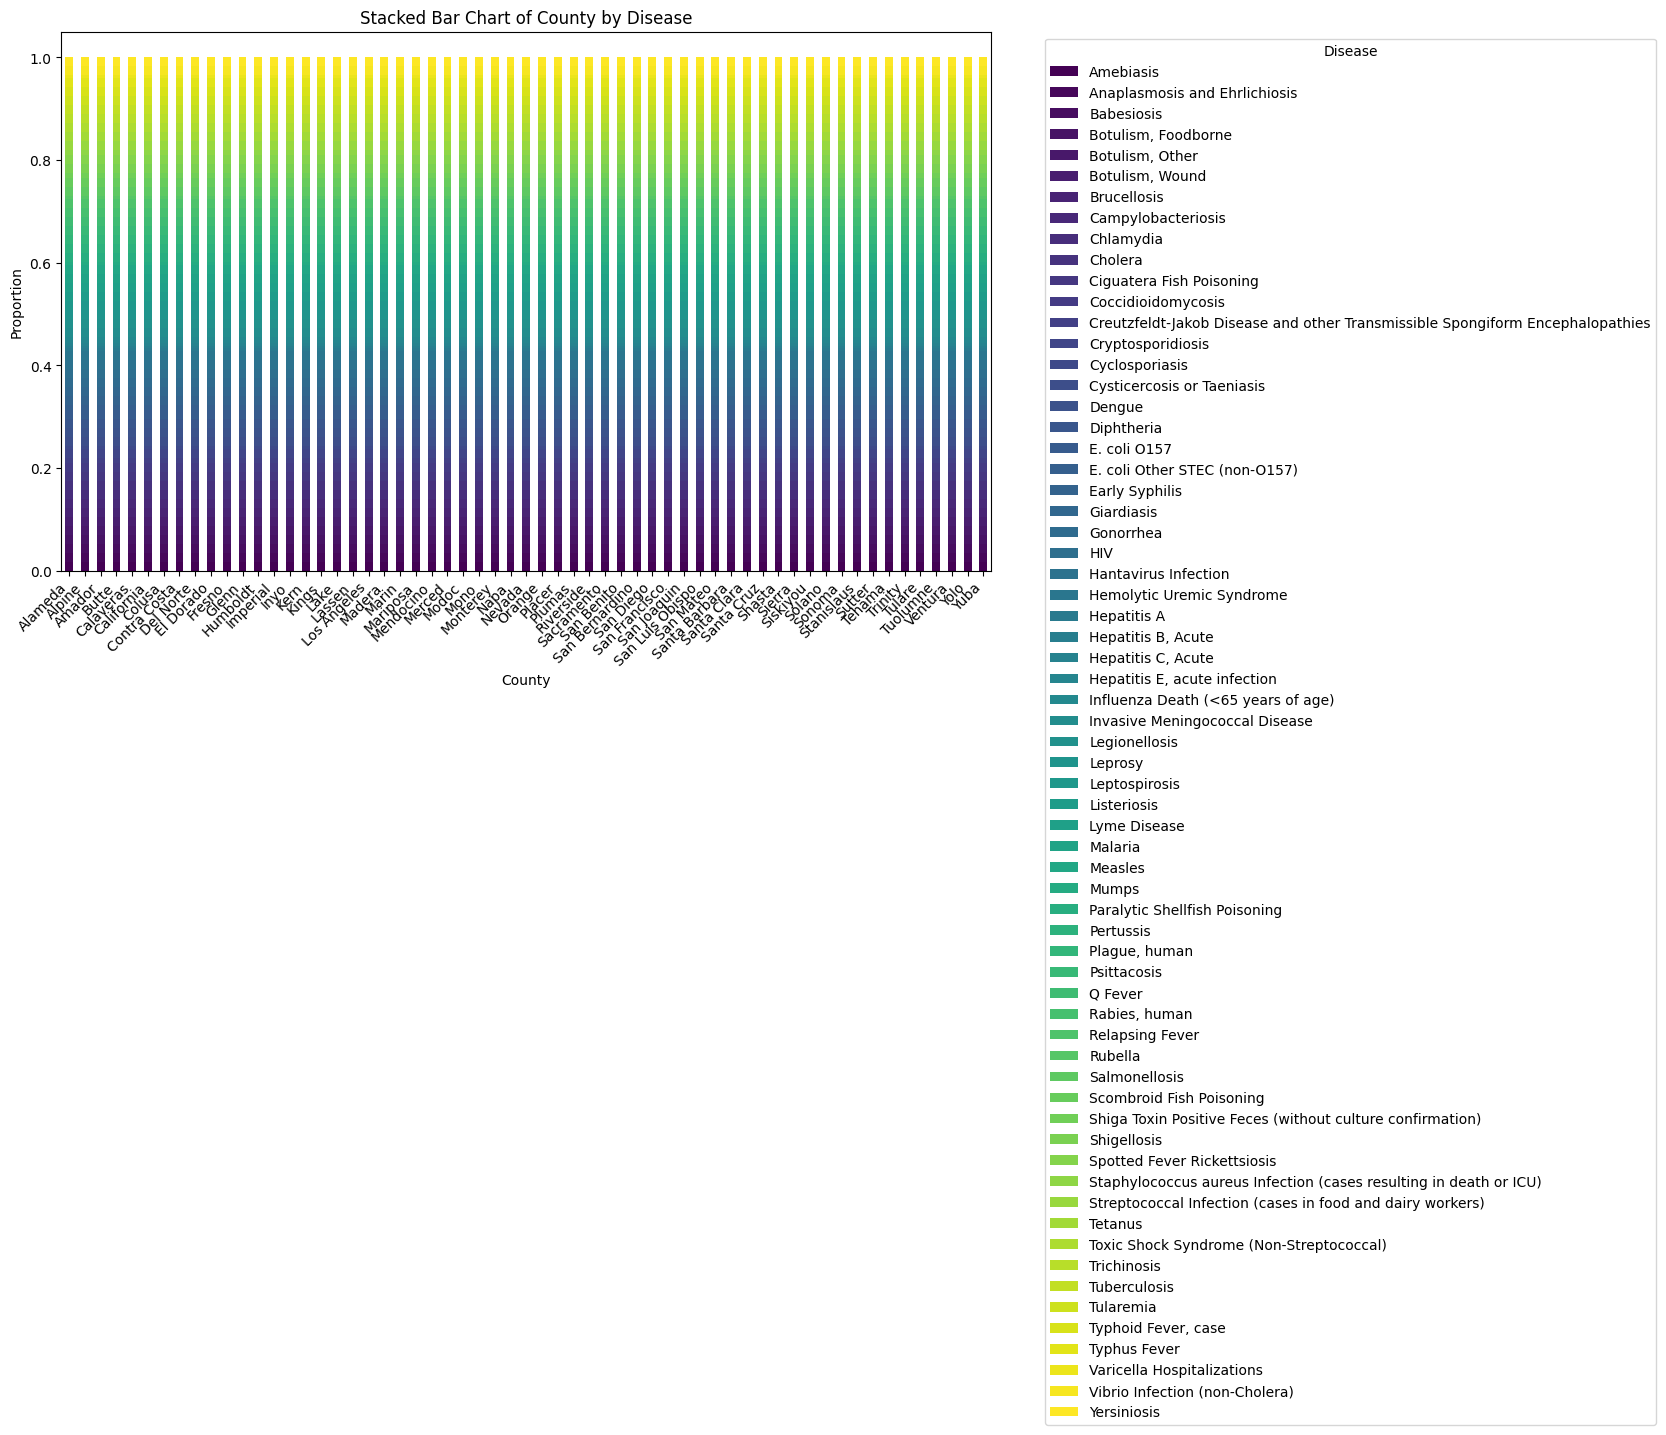

In [107]:
# Relationships with Target Variable ---

if target_column in df.columns:
    if numerical_cols:
        num_col_for_target = numerical_cols[0]
        #  Box Plot of a numerical feature vs. target
        print(f"\n Box Plot: {num_col_for_target} by {target_column}")
        plt.figure(figsize=(10, 7))
        sns.boxplot(data=df, x=target_column, y=num_col_for_target, palette='viridis')
        plt.title(f'Box Plot of {num_col_for_target} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(num_col_for_target)
        plt.tight_layout()
        plt.show()

        #  Violin Plot of a numerical feature vs. target
        print(f"\n Violin Plot: {num_col_for_target} by {target_column}")
        plt.figure(figsize=(10, 7))
        sns.violinplot(data=df, x=target_column, y=num_col_for_target, palette='viridis')
        plt.title(f'Violin Plot of {num_col_for_target} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(num_col_for_target)
        plt.tight_layout()
        plt.show()
    else:
        print("No numerical features to plot against the target.")

    if categorical_cols:
        cat_col_for_target = categorical_cols[0]
        # 16. Count Plot of a categorical feature vs. target (with hue)
        print(f"\n Count Plot: {cat_col_for_target} by {target_column}")
        plt.figure(figsize=(12, 7))
        sns.countplot(data=df, x=cat_col_for_target, hue=target_column, palette='viridis',
                      order=df[cat_col_for_target].value_counts().index)
        plt.title(f'Count Plot of {cat_col_for_target} by {target_column}')
        plt.xlabel(cat_col_for_target)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=target_column, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        #  Stacked Bar Chart of a categorical feature vs. target
        print(f"\n Stacked Bar Chart: {cat_col_for_target} by {target_column}")
        cross_tab_target = pd.crosstab(df[cat_col_for_target], df[target_column], normalize='index')
        cross_tab_target.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='viridis')
        plt.title(f'Stacked Bar Chart of {cat_col_for_target} by {target_column}')
        plt.xlabel(cat_col_for_target)
        plt.ylabel('Proportion')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=target_column, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("No categorical features to plot against the target.")
else:
    print(f"Target column '{target_column}' not found in DataFrame for target-specific plotting.")


 KDE Plot of Count conditioned by Disease


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\644344882.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


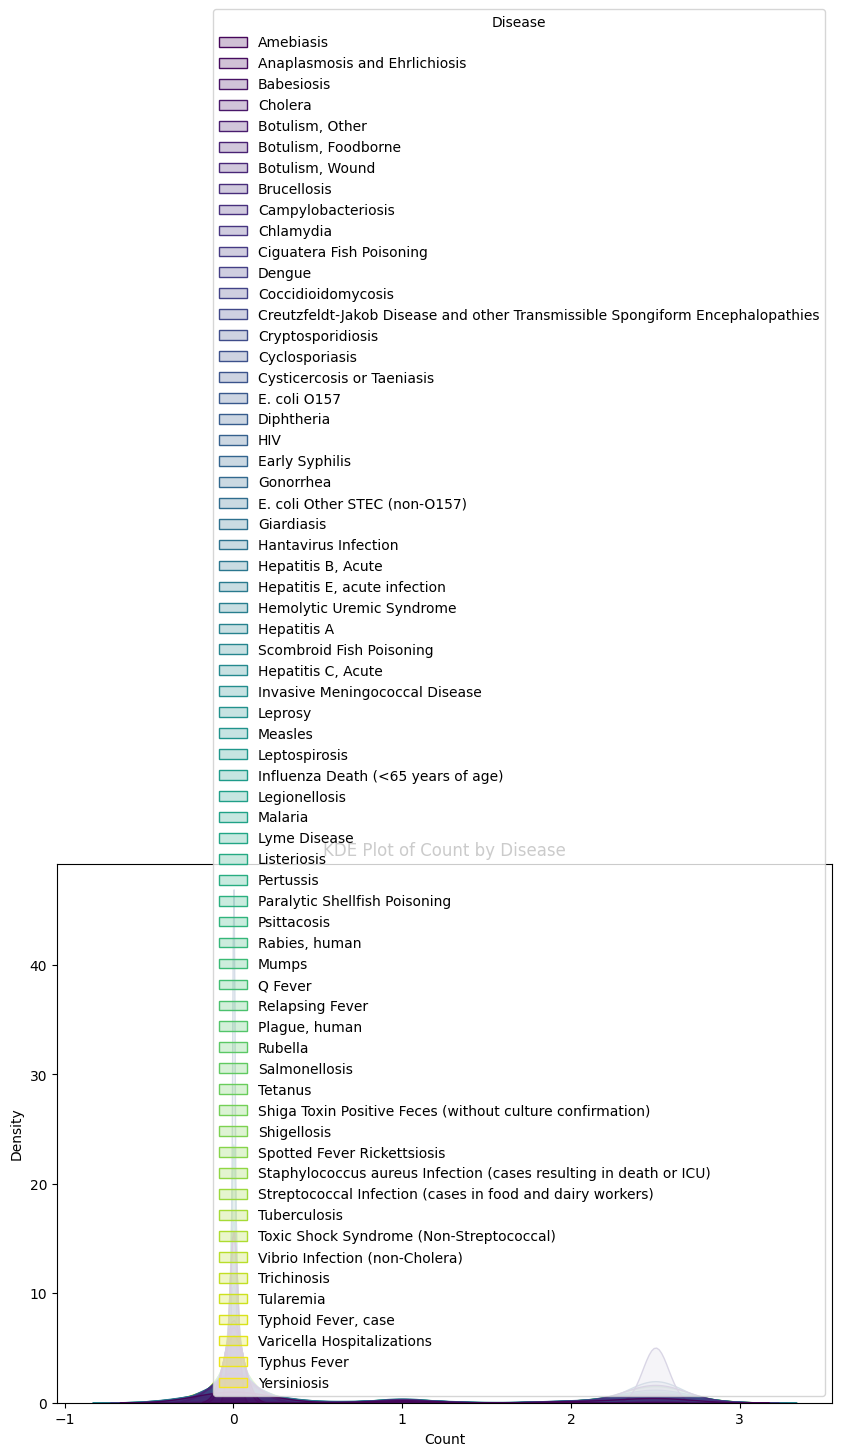


 Scatter Plot: Count vs. Population colored by Disease


C:\Users\USER\AppData\Local\Temp\ipykernel_28872\644344882.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


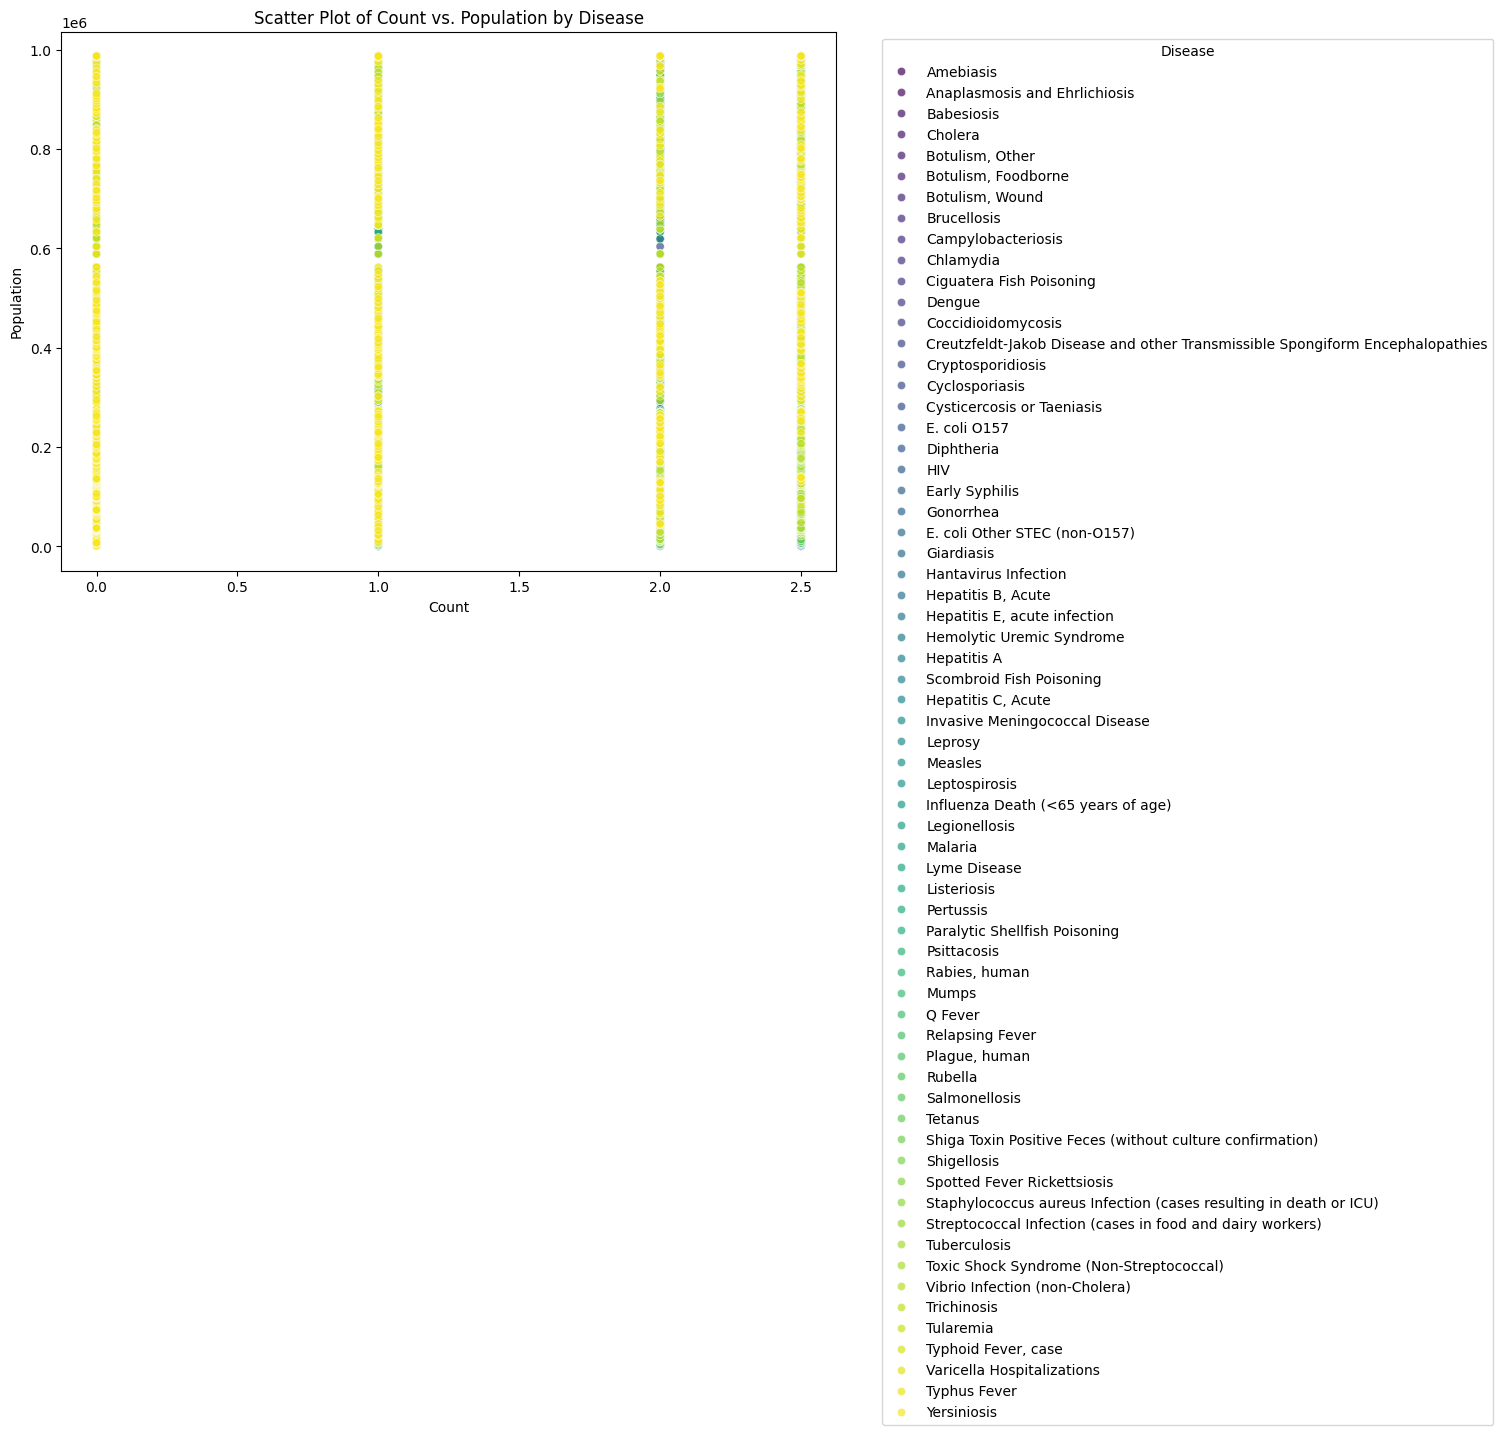


 Swarm Plot: Count by County colored by Disease


h:\BT\Infectious_Disease_Using_BLSTM_BGRU_Model\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 97.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
h:\BT\Infectious_Disease_Using_BLSTM_BGRU_Model\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 90.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
h:\BT\Infectious_Disease_Using_BLSTM_BGRU_Model\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 92.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
h:\BT\Infectious_Disease_Using_BLSTM_BGRU_Model\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 95.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

In [ ]:
#  Advanced/Specific Plots ---
if target_column in df.columns:
    if numerical_cols:
        num_col_adv = numerical_cols[0]
        #  Distribution of a specific numerical feature, conditioned by target (KDE plot with hue)
        print(f"\n KDE Plot of {num_col_adv} conditioned by {target_column}")
        plt.figure(figsize=(10, 7))
        sns.kdeplot(data=df, x=num_col_adv, hue=target_column, fill=True, common_norm=False, palette='viridis')
        plt.title(f'KDE Plot of {num_col_adv} by {target_column}')
        plt.xlabel(num_col_adv)
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

    if len(numerical_cols) >= 2:
        num_col_adv1, num_col_adv2 = numerical_cols[0], numerical_cols[1]
        # Scatter plot of two numerical features, colored by target
        print(f"\n Scatter Plot: {num_col_adv1} vs. {num_col_adv2} colored by {target_column}")
        plt.figure(figsize=(10, 7))
        sns.scatterplot(data=df, x=num_col_adv1, y=num_col_adv2, hue=target_column, palette='viridis', alpha=0.7)
        plt.title(f'Scatter Plot of {num_col_adv1} vs. {num_col_adv2} by {target_column}')
        plt.xlabel(num_col_adv1)
        plt.ylabel(num_col_adv2)
        plt.legend(title=target_column, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    if numerical_cols and categorical_cols:
        num_col_adv_swarm = numerical_cols[0]
        cat_col_adv_swarm = categorical_cols[0]
        # Swarm plot of a numerical feature by a categorical feature, colored by target
        print(f"\n Swarm Plot: {num_col_adv_swarm} by {cat_col_adv_swarm} colored by {target_column}")
        plt.figure(figsize=(12, 7))
        sns.swarmplot(data=df, x=cat_col_adv_swarm, y=num_col_adv_swarm, hue=target_column, palette='viridis', dodge=True)
        plt.title(f'Swarm Plot of {num_col_adv_swarm} by {cat_col_adv_swarm} by {target_column}')
        plt.xlabel(cat_col_adv_swarm)
        plt.ylabel(num_col_adv_swarm)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=target_column, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numerical and/or categorical features for advanced plotting with target.")
else:
    print(f"Target column '{target_column}' not found in DataFrame for advanced plotting.")

print("\n--- All 20 visualizations attempted. ---")
